<a href="https://colab.research.google.com/github/rubeshajith/NETFLIX-MOVIES-AND-TV-SHOWS-CLUSTERING/blob/main/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

## <b>In this  project, you are required to do </b>
1. Exploratory Data Analysis 

2. Understanding what type content is available in different countries

3. Is Netflix has increasingly focusing on TV rather than movies in recent years.
4. Clustering similar content by matching text-based features



# **Attribute Information**

1. show_id : Unique ID for every Movie / Tv Show

2. type : Identifier - A Movie or TV Show

3. title : Title of the Movie / Tv Show

4. director : Director of the Movie

5. cast : Actors involved in the movie / show

6. country : Country where the movie / show was produced

7. date_added : Date it was added on Netflix

8. release_year : Actual Releaseyear of the movie / show

9. rating : TV Rating of the movie / show

10. duration : Total Duration - in minutes or number of seasons

11. listed_in : Genere

12. description: The Summary description

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Integrating original dataset with IMDB ratings

The Netflix datset does not include any information on viewers ratings; We can get users rating info from IMDB. They make their data available at https://datasets.imdbws.com.

In [4]:
# Reading orginal dataframe provided

# df = pd.read_csv("/content/drive/MyDrive/data/project/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

Since the IMDB database is so vast, it comes in multiple files. We only grabbed the two that we need to make a connection to the Netflix data: 'title.ratings.tsv' and 'title.basics.tsv'.

In [5]:
# Path of IMDB files

# basic_df = pd.read_csv("/content/drive/MyDrive/data/project/title_data.tsv",sep='\t')
# rating_df = pd.read_csv("/content/drive/MyDrive/data/project/rating_data.tsv",sep='\t')

In basic_df, titleType variable had many values like tvepisode, tvseries, tvspecial, tvshort, tvminiseries and tvmovie, so let's just rename them to tv show and movie so that later on we can merge them to our orginal dataset

In [6]:
# Manipluating column titleType from basic_df as per above text

# basic_df['titleType'] = basic_df['titleType'].str.lower()
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvepisode', 'tv show')
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvseries', 'tv show')
# basic_df['titleType'] = basic_df['titleType'].str.replace('tvmovie', 'movie')


Let's combine our two IMDb dataframes into a single dataframe, We will accomplish this by joining them on their 'tconst' column and making this the index of the resulting dataframe.

In [7]:
# Merging above two dataframes with "tconst" as index

# imdb_df= pd.merge(basic_df.set_index('tconst'), rating_df.set_index('tconst'), left_index=True, right_index=True)

In [8]:
#Lower casing title and type for both original and imdb dataset for merging purpose

# df['title']= df['title'].str.lower()
# df['type']= df['type'].str.lower()

# imdb_df['primaryTitle'] = imdb_df['primaryTitle'].str.lower()
# imdb_df['originalTitle'] = imdb_df['originalTitle'].str.lower()


In [9]:
# Segregating and changing datatype for startYear feature

# imdb_df = imdb_df[imdb_df.startYear.apply(lambda x: str(x).isnumeric())]
# imdb_df['startYear'] = imdb_df['startYear'].astype(int)


Splitting tvshow and movie data from our original dataset for merging accordingly

In [10]:
# tv_show_df = df[df["type"]== "tv show"]
# tv_show_df.shape
# (2410, 12)

In [11]:
# movie_df = df[df["type"]== "movie"]
# movie_df.shape
# (5377, 12)

In [12]:
# Merging tv show data w.r.t title and type by using left join for retaining our original dataframe

# tv_final_df = pd.merge(tv_show_df, imdb_df, left_on=['title',"type"], right_on=['primaryTitle',"titleType"],how="left")
# tv_final_df.shape
# (5894, 22)

* The best choice for merging tv show data was to just by merging them with title(name) and type(tvshow) because in our original dataset, tv_show set had release year which contained final seasons release year, whereas in IMDb dataset we had two column startYear and endYear, in which we have to pick endYear but it contained more nullvalues, so we just merged them with title name and type






* In the above tv_final_df we can see its shape has increased more than twice, since imdb dataset had many rating for same tv show title, might be of season wise review

In [13]:
# Merging movie data w.r.t title and release_year by using left join for retaining our original dataframe

# movie_final_df = pd.merge(movie_df, imdb_df, left_on=['title','release_year'], right_on=['primaryTitle','startYear'],how="left")
# movie_final_df.shape
# (6056, 22)

In this the best choice was to merge by title and release year, since movie name can be same for few with the help of year we merged them

After merging movie df, it also increased in shape, similar movies had many different reviews or rating value

In [14]:
# Concating both movies and tv show df together

# final_frame = pd.concat([tv_final_df,movie_final_df])
# final_frame.shape
# (11950, 22)

We can see the final frame df shape its larger than our orginal datset, we had many rating values for same title name , so we'll just pick the maximum in numVotes(no. of people voted for that movie) column from repeated rows. Because it would be odd to choose maximum in average_rating since less voted movie might have higher average_rating, so we'll just pick max in numVotes column

In [15]:
# filling Nan values in numVotes column with 0, since we had to perform max method

# final_frame['numVotes'] = final_frame['numVotes'].fillna(0)

In [16]:
# Grouping as per above text

# final_frame = final_frame.groupby('title',as_index=False).apply(lambda x:x.loc[x.numVotes.idxmax()])
# final_frame.shape
# (7787, 22)

* After picking maximum value in numVotes, we can see we are retaining original dataframe shape with extra columns(imdb rating) which will be useful for EDA

* We obtained 5994 number of title's rating

* We inspected top and bottom 100 rows, and found no error (we found "release_year" in either "startYear" or "endYear" column of imdb dataset) in matching by year, since we didnt match tv shows by year 

* Since it took more time and memory we'll just convert the final_frame to csv and comment the above code

In [17]:
# Converting the final dataframe to csv 

# final_frame.to_csv(r"/content/drive/MyDrive/data/project/netflix_imdb.csv", index=False)

In [18]:
# Reading imdb integrated dataframe

df = pd.read_csv("/content/drive/MyDrive/data/project/netflix_imdb.csv")

In [19]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s28,movie,#alive,Cho Il,"Yoo Ah-in, Park Shin-hye",South Korea,"September 8, 2020",2020,TV-MA,99 min,"Horror Movies, International Movies, Thrillers","As a grisly virus rampages a city, a lone man ...",movie,#alive,#saraitda,0.0,2020.0,\N,98,"Action,Drama,Horror",6.3,38671.0
1,s29,movie,#annefrank - parallel stories,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",Italy,"July 1, 2020",2019,TV-14,95 min,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,s30,tv show,#blackaf,NaN,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,"April 17, 2020",2020,TV-MA,1 Season,TV Comedies,Kenya Barris and his family navigate relations...,tv show,#blackaf,#blackaf,0.0,2020.0,2020,36,Comedy,6.6,4850.0
3,s31,movie,#cats_the_mewvie,Michael Margolis,NaN,Canada,"February 5, 2020",2020,TV-14,90 min,"Documentaries, International Movies",This pawesome documentary explores how our fel...,movie,#cats_the_mewvie,#cats_the_mewvie,0.0,2020.0,\N,90,Documentary,5.3,468.0
4,s32,movie,#friendbutmarried,Rako Prijanto,"Adipati Dolken, Vanesha Prescilla, Rendi Jhon,...",Indonesia,"May 21, 2020",2018,TV-G,102 min,"Dramas, International Movies, Romantic Movies","Pining for his high school crush for years, a ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Since we lastly performed Groupby operating the title have been arranged in order, lets just rearrange them with respect to original dataframe with the help of "show_id"

In [20]:
# Manipulating as per above text

df['indexNumber'] = df["show_id"].replace("s","",regex=True).astype(int)
df.sort_values(['indexNumber'], ascending = [True], inplace = True)
df = df.reset_index()
df.drop(['indexNumber',"index"], 1, inplace = True)


Keeping just the imdb "runtimeMinutes", "averageRating", "numVotes" lets drop all other columns from imdb dataset part

In [21]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear',
       'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes'],
      dtype='object')

In [22]:
df = df.drop(["titleType","primaryTitle","originalTitle","isAdult","startYear","endYear","genres"],axis=1)

# 1. Exploratory Data Analysis

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         7787 non-null   object 
 1   type            7787 non-null   object 
 2   title           7787 non-null   object 
 3   director        5398 non-null   object 
 4   cast            7069 non-null   object 
 5   country         7280 non-null   object 
 6   date_added      7777 non-null   object 
 7   release_year    7787 non-null   int64  
 8   rating          7780 non-null   object 
 9   duration        7787 non-null   object 
 10  listed_in       7787 non-null   object 
 11  description     7787 non-null   object 
 12  runtimeMinutes  5994 non-null   object 
 13  averageRating   5994 non-null   float64
 14  numVotes        7787 non-null   float64
dtypes: float64(2), int64(1), object(12)
memory usage: 912.7+ KB


1793 missing values from imdb part

In [24]:
nan_percentile = {"columns_with_nan":[],"nan_percentile":[]}
for i in df.columns:
  nan_perc = df[i].isna().sum() / len(df) * 100
  if nan_perc > 0:
    nan_percentile["columns_with_nan"].append(i)
    nan_percentile["nan_percentile"].append(round(nan_perc,2))

In [25]:
# Creating Nan DataFrame
nan_per = pd.DataFrame(nan_percentile)
nan_per = nan_per.sort_values(by= "nan_percentile", ascending= False)
nan_per

,columns_with_nan,nan_percentile
0,director,30.68
5,runtimeMinutes,23.03
6,averageRating,23.03
1,cast,9.22
2,country,6.51
3,date_added,0.13
4,rating,0.09


Text(0.5, 0, 'Nan percentile')

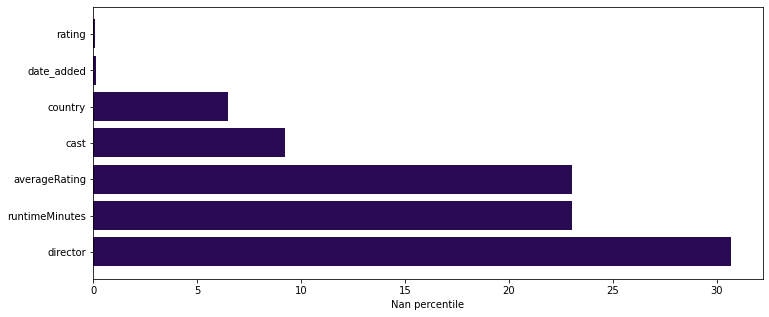

In [26]:
#Visualizing missing percentile

plt.figure(figsize=(12,5))
sns.set_palette("inferno")
plt.barh(nan_per["columns_with_nan"], nan_per["nan_percentile"])
plt.xlabel("Nan percentile")

<Figure size 1080x432 with 0 Axes>

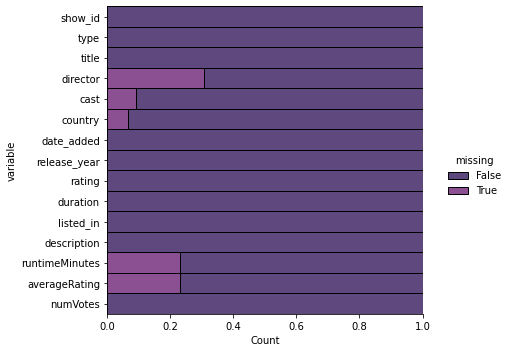

In [27]:
#Visualizing missing and non missing values in our dataframe

plt.figure(figsize=(15,6))
sns.displot(data=df.isna().melt(value_name="missing"), y="variable",hue="missing",multiple="fill", aspect=1.25)

# 1.1 Handling NULL values

In [28]:
# df[df["country"].isna()]

After going through titles and cast names in our df of country NaN value, i figured out few rows which contained indian movies and tv shows, so lets assign those rows with our country name. Below are the rows which were inspected to be Indian movies or tv_shows

In [29]:
indian_mov_rows = [509,525,548,657,658,659,661,662,889,1124,1318,1319,1320,1321,3444,3445,3446,3447,3449,3450,3451,3454,3470,3668,3669,3670,3671,3672,3673,3674,
4043,4341,4441,4594,4595,4839,5035,5036,5049,5395,5396,5402,6040]

In [30]:
# Adding country name as India for the above rows which were inspected

for index_num in indian_mov_rows:
  df.loc[index_num,"country"] = "India"

* Rest Nan values for country, we'll just add highest movies and tvshows made by a country which is United States

* Rest Feature's Nan values are filled with "No Data" for categorical  and 0 for numerical 

In [31]:
# Manipulating data by above text

df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].fillna("No Data")
df['director'] = df['director'].fillna("No Data")
df['averageRating'] = df['averageRating'].fillna(0)
df['runtimeMinutes'] = df['runtimeMinutes'].fillna(0)

In [32]:
df[df["rating"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes
67,s68,movie,13th: a conversation with oprah winfrey & ava ...,No Data,"Oprah Winfrey, Ava DuVernay",United States,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...,37,7.0,205.0
2359,s2360,tv show,gargantia on the verdurous planet,No Data,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel...",\N,7.4,1669.0
3660,s3661,tv show,little lunch,No Data,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take...",13,8.3,500.0
3736,s3737,movie,louis c.k. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi...",74,7.6,10248.0
3737,s3738,movie,louis c.k.: hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...,82,8.4,12126.0
3738,s3739,movie,louis c.k.: live at the comedy store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...,66,7.8,6567.0
4323,s4324,movie,my honor was loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c...",0,0.0,0.0


Since ther are only 7 rows so lets just browse the rating from internet and replace them

In [33]:
rating_replacements = {67:"TV-PG",2359:"TV-14",3660:"TV-MA",3736:"TV-MA",3737:"NR",3738:"TV-MA",4323:"TV-MA"}
for index, rate in rating_replacements.items():
  df.loc[index, "rating"] = rate

In [34]:
df.isna().sum()

show_id            0
type               0
title              0
director           0
cast               0
country            0
date_added        10
release_year       0
rating             0
duration           0
listed_in          0
description        0
runtimeMinutes     0
averageRating      0
numVotes           0
dtype: int64

In [35]:
df[df["date_added"].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes
258,s259,tv show,a young doctor's notebook and other stories,No Data,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",0,0.0,0.0
549,s550,tv show,anthony bourdain: parts unknown,No Data,Anthony Bourdain,United States,NaN,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...,42,8.8,6212.0
2263,s2264,tv show,frasier,No Data,"Kelsey Grammer, Jane Leeves, David Hyde Pierce...",United States,NaN,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...,22,8.2,83332.0
2288,s2289,tv show,friends,No Data,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaN,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...,22,8.9,970970.0
2555,s2556,tv show,gunslinger girl,No Data,"Yuuka Nanri, Kanako Mitsuhashi, Eri Sendai, Am...",Japan,NaN,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe...",24,7.3,2221.0
3374,s3375,tv show,kikoriki,No Data,Igor Dmitriev,United States,NaN,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...,6,7.7,949.0
3492,s3493,tv show,la familia p. luche,No Data,"Eugenio Derbez, Consuelo Duval, Luis Manuel Áv...",United States,NaN,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder...",\N,7.8,948.0
3946,s3947,tv show,maron,No Data,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews...",22,7.7,5008.0
5137,s5138,tv show,red vs. blue,No Data,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil...",6,8.4,9426.0
6065,s6066,tv show,the adventures of figaro pho,No Data,"Luke Jurevicius, Craig Behenna, Charlotte Haml...",Australia,NaN,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ...",\N,7.5,167.0


After browsing we found a website which contained netfix news, which we made use of and found the below dates which was the actual date added by netflix

Also Friends is one of my favourite tv show so, lets just browse and fill them instead of dropping them

In [36]:
# Replacing Nan value of date_added by netflix through internet

df.loc[258,"date_added"] = "September 15, 2014"
df.loc[549,"date_added"] = "September 15, 2014"
df.loc[2263,"date_added"] = "April 6, 2016"
df.loc[2288,"date_added"] = "January 1, 2015"
df.loc[2555,"date_added"] = "January 4, 2016"
df.loc[3374,"date_added"] = "July 6, 2017"
df.loc[3492,"date_added"] = "June 1, 2015"
df.loc[3946,"date_added"] = "January 13, 2017"
df.loc[5137,"date_added"] = "September 15, 2014"
df.loc[6065,"date_added"] = "September 15, 2014"

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         7787 non-null   object 
 1   type            7787 non-null   object 
 2   title           7787 non-null   object 
 3   director        7787 non-null   object 
 4   cast            7787 non-null   object 
 5   country         7787 non-null   object 
 6   date_added      7787 non-null   object 
 7   release_year    7787 non-null   int64  
 8   rating          7787 non-null   object 
 9   duration        7787 non-null   object 
 10  listed_in       7787 non-null   object 
 11  description     7787 non-null   object 
 12  runtimeMinutes  7787 non-null   object 
 13  averageRating   7787 non-null   float64
 14  numVotes        7787 non-null   float64
dtypes: float64(2), int64(1), object(12)
memory usage: 912.7+ KB


# 1.2 Feature Manipulation

Let's Generate new columns based on variables

Year and month

In [38]:
# Creating new varaibles

df["date_added"] = pd.to_datetime(df['date_added'])
df["month"] = df["date_added"].dt.month_name()
df["year_added"] = df["date_added"].dt.year

In [39]:
# Splitting movie and tv show data

tv_show_df = df[df["type"]=="tv show"]
movie_df = df[df["type"]=="movie"]

Runtime for movie and Runtime per episode for tv show

In [40]:
# Creating new column "runtime_in_min" with the help of duration in our original dataset and "runtimeMinutes" from imdb dataset

df.loc[df["type"]== "movie", "runtime_in_min"] = movie_df["duration"]
df.loc[df["type"]== "tv show", "runtime_in_min"] = tv_show_df["runtimeMinutes"]

df["runtime_in_min"] = df["runtime_in_min"].fillna(0)                       #filling Nan values with 0     
df['runtime_in_min'] = df["runtime_in_min"].replace("min","",regex=True)    #removing min string 
df['runtime_in_min'] = df["runtime_in_min"].replace("\\N",0).astype(int)    #converting to int datatype


Age Targets based on rating

In [41]:
# Creating new feature rating by ages

ratings_ages = {'TV-PG': 'Older Kids', 'TV-MA': 'Adults','TV-Y7-FV': 'Older Kids','TV-Y7': 'Older Kids','TV-14': 'Teens','R': 'Adults',
  'TV-Y': 'Kids','NR': 'Adults','PG-13': 'Teens','TV-G': 'Kids','PG': 'Older Kids','G': 'Kids','UR': 'Adults','NC-17': 'Adults'}
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Adults', 'Teens', 'Older Kids', 'Kids'], dtype=object)

In [42]:
# checking new variables
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes,month,year_added,runtime_in_min,target_ages
0,s1,tv show,3%,No Data,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,49,7.3,25545.0,August,2020,49,Adults
1,s2,movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,94,5.8,655.0,December,2016,93,Adults
2,s3,movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",78,4.5,979.0,December,2018,78,Adults
3,s4,movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",79,7.0,139874.0,November,2017,80,Teens
4,s5,movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,123,6.8,250161.0,January,2020,123,Teens


#1.3 Data Visualization

In [43]:
# Creating color pallete

netflix_color_code = ['#221f1f','#b20710','#e50914','#f5f5f1']
netflix_palette = sns.set_palette(sns.color_palette(netflix_color_code))

###Movie And Tv Show Ratio

In [44]:
# checking actual value_counts
df['type'].value_counts()

movie      5377
tv show    2410
Name: type, dtype: int64

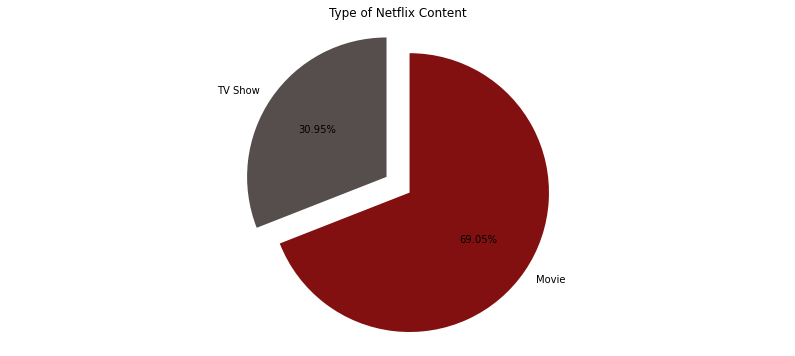

In [45]:
# plotting pie chart for type column

plt.figure(figsize=(14, 6))
labels=['TV Show', 'Movie']
plt.pie(df['type'].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],autopct='%1.2f%%',
        colors=['#564d4d','#831010'], startangle=90)
plt.title('Type of Netflix Content')
plt.axis('equal')
plt.show()

* About 69% are movies and 31% are tv shows in our dataset
* We have 5377 movies and 2410 tv shows in actual numbers

### Top Countries with more contribution in netflix

In [46]:
# manipulating because few movies have more country names
filtered_countries = df["country"].str.split(", ")
filtered_countries = filtered_countries.explode("country")

In [227]:
# creating dataframe by counts
filtered_countries.value_counts()[0:10].to_frame(name= "Counts").T

,United States,India,United Kingdom,Canada,France,Japan,Spain,South Korea,Germany,Mexico
Counts,3760,1033,722,412,349,287,215,212,199,154


### Top countries by content count

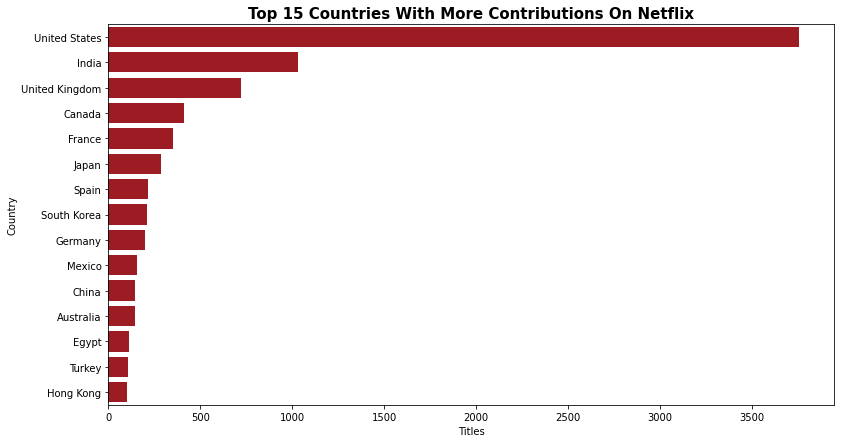

In [48]:
# plotting them by countplot

plt.figure(figsize=(13,7))
g = sns.countplot(y = filtered_countries, order=filtered_countries.value_counts().index[:15], color='#b20710')
plt.title('Top 15 Countries With More Contributions On Netflix', fontsize=15, fontweight='bold')
plt.xlabel('Titles')
plt.ylabel('Country')
plt.show()

The Top 3 countries with most contributions are namely United States with	3760 contents, India with 1033 contents and United Kingdom with	722 contents for netflix

### Top Countries By Content Type

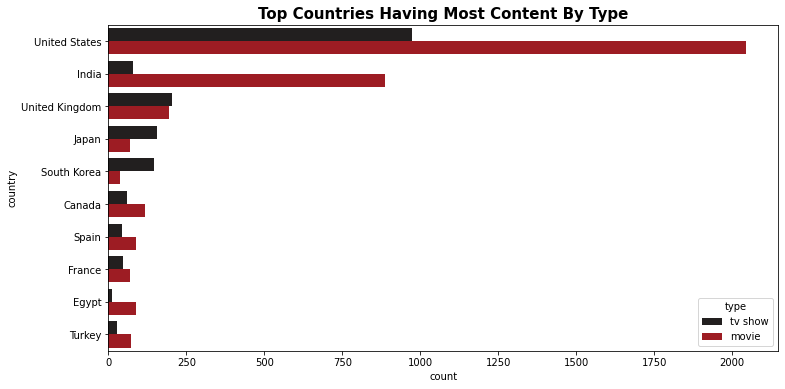

In [49]:
# plotting Top Countries By Content Type with countplot
fig = plt.figure(figsize=(12,6))
sns.countplot(data = df,y = 'country', order = df["country"].value_counts().index[:10],hue = 'type',palette = netflix_palette)
plt.title("Top Countries Having Most Content By Type", fontsize=15, fontweight='bold')
plt.show()

* The Top two countries United States and India are intrested in contributing more movies than tv shows.
* United Kingdom is giving equal weightage for both movies and tv shows
* Japan and South Korea is focusing more on tv shows
* Rest all other countries in lower bracket are clearly concentrating on movies

### Top Rating By Content (Type)

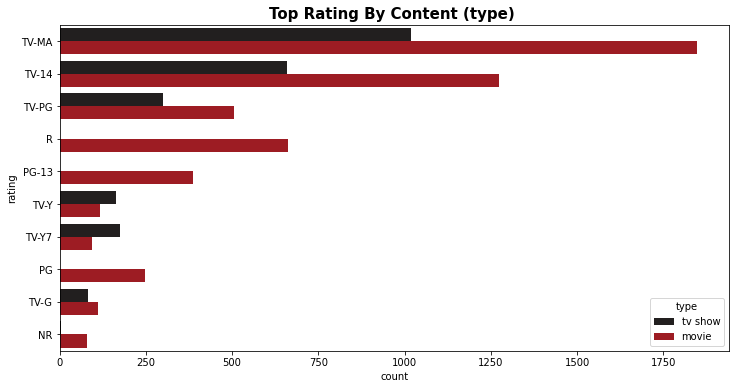

In [50]:
# plotting Top Rating By Content (Type) with countplot
fig = plt.figure(figsize=(12,6))
sns.countplot(data = df,y = 'rating', order = df["rating"].value_counts().index[:10],hue = 'type',palette = netflix_palette)
plt.title("Top Rating By Content (type) ", fontsize=15, fontweight='bold')
plt.show()

* The Top most produced movies and tv shows based on rating is TV-MA(Mature audience) and secondly is TV-14 which is for Teen audience 

### Age Target By Rating and Type of Content

In [51]:
# separating age rating with help of internet for plotting purpose

movie_age_rate = {'Little_Kids': ['G', 'TV-Y', 'TV-G'],'Older_Kids':['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG'],'Teens': ['PG-13', 'TV-14'],
                 'Mature':['R', 'NC-17', 'TV-MA']}
tv_show_age_rate = {'Little_Kids': ['TV-Y', 'TV-G'],'Older_Kids':['TV-Y7', 'TV-Y7-FV', 'TV-PG'],'Teens': ['TV-PG','TV-14'],
                 'Mature':['R', 'TV-MA']}

Text(0.5, 0.98, 'Tv Show Split Rating Vs Count ')

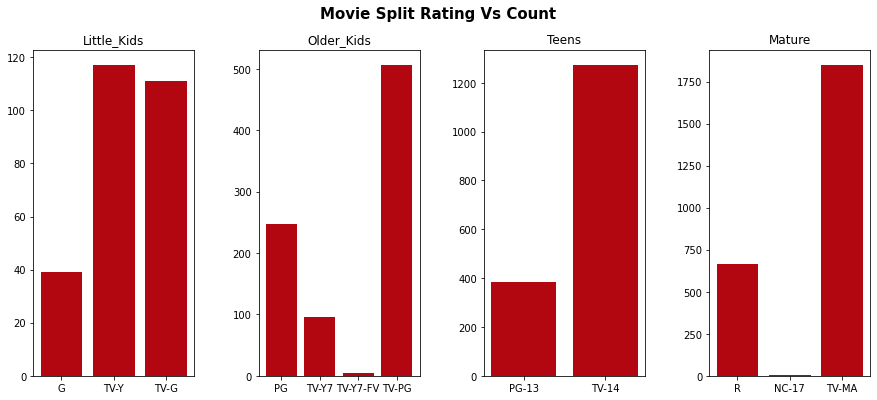

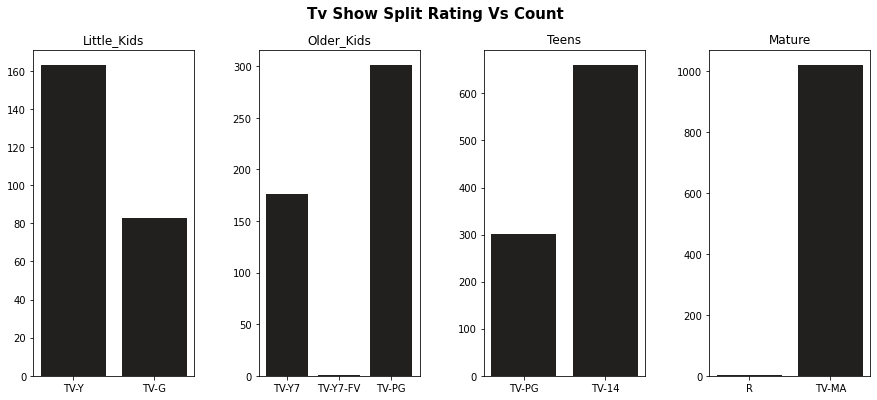

In [52]:
# plotting age target by rating and type of content

i=0
plt.figure(figsize=(15,6))
for ind, values in movie_age_rate.items():
  data = []
  data = movie_df["rating"].value_counts()[movie_age_rate[ind]]
  plt.subplot(1,4,i+1)
  plt.bar(data.index,data,color='#b20710')
  plt.title(ind)
  i=i+1
  plt.subplots_adjust(wspace=0.4)
plt.suptitle("Movie Split Rating Vs Count", fontsize=15, fontweight='bold')

i=0
plt.figure(figsize=(15,6))
for ind, values in tv_show_age_rate.items():
  data = []
  data = tv_show_df["rating"].value_counts()[tv_show_age_rate[ind]]
  plt.subplot(1,4,i+1)
  plt.bar(data.index,data,color='#221f1f')
  plt.title(ind)
  i=i+1
  plt.subplots_adjust(wspace=0.4)
plt.suptitle("Tv Show Split Rating Vs Count ", fontsize=15, fontweight='bold')


* Above are the Ratings counts based on Target ages

### Top Genres by Content Type with Count

In [53]:
# manipulating listed_in columns since one movie can have many genres

exploded_listed_in = df[["show_id","type","listed_in"]]
exploded_listed_in["listed_in"] = exploded_listed_in["listed_in"].str.split(", ")
exploded_listed_in = exploded_listed_in.explode("listed_in")
exploded_listed_in_movie = exploded_listed_in.loc[exploded_listed_in["type"]== "movie"]
exploded_listed_in_tv_show = exploded_listed_in.loc[exploded_listed_in["type"]== "tv show"]

Text(0.5, 1.0, 'Top Genres In Tv Show By Count')

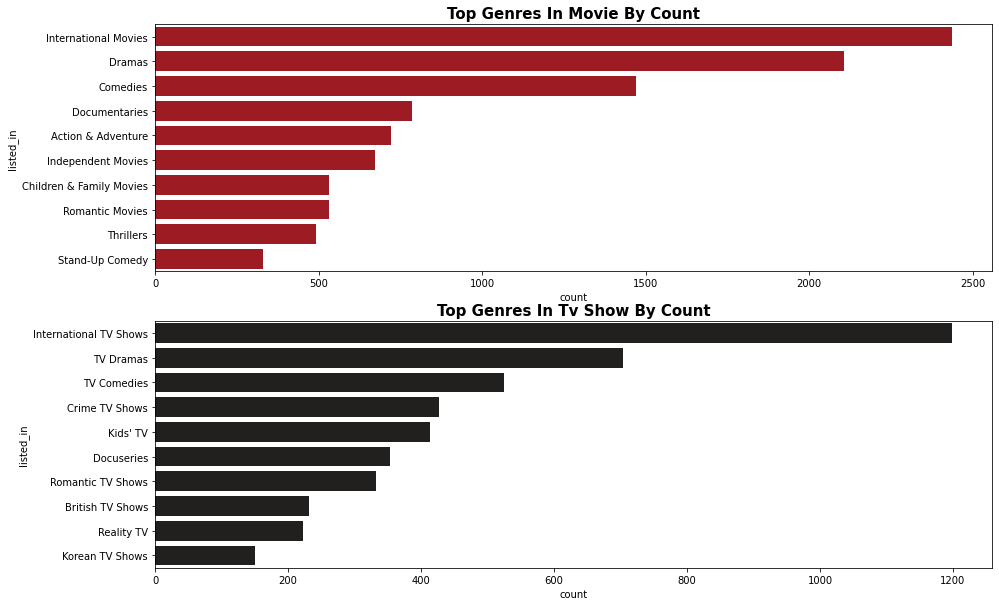

In [54]:
# plotting top genres by content type
fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.countplot(data = exploded_listed_in_movie ,y = 'listed_in', order = exploded_listed_in_movie["listed_in"].value_counts().index[:10]
              ,color='#b20710')
plt.title("Top Genres In Movie By Count", fontsize=15, fontweight='bold')

plt.subplot(2,1,2)
sns.countplot(data = exploded_listed_in_tv_show ,y = 'listed_in', order = exploded_listed_in_tv_show["listed_in"].value_counts().index[:10]
              ,color='#221f1f')
plt.title("Top Genres In Tv Show By Count", fontsize=15, fontweight='bold')

* The Top 3 Genres for movies is International movies, Dramas and Comedies
* The Top 3 Genres for Tv shows os International Tv shows, TV Dramas and TV Comedies

### Top Release Year And Year Added On Netflix By Content (Type)

Text(0.5, 1.0, 'YEAR ADDED ON NETFLIX OF MOVIES')

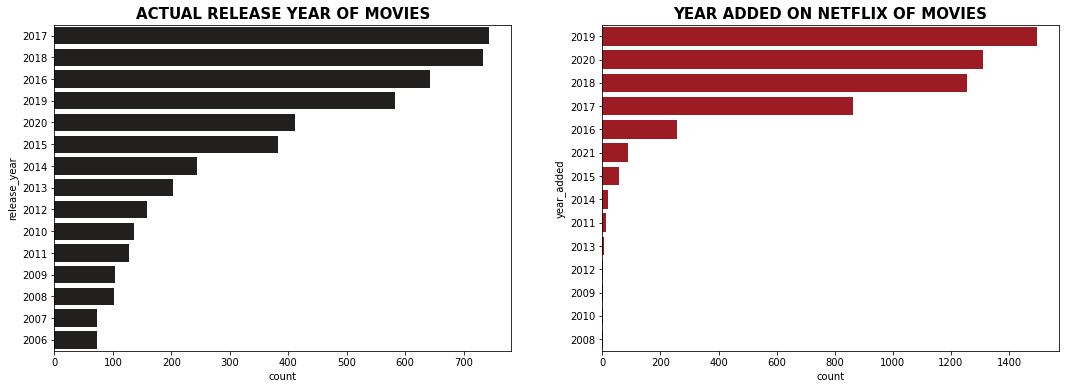

In [55]:
# plotting actual and netflix added year for movie part
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.countplot(y="release_year", data=movie_df, color="#221f1f", order=movie_df['release_year'].value_counts().index[0:15])
plt.title('ACTUAL RELEASE YEAR OF MOVIES', fontsize=15, fontweight='bold')

plt.subplot(1,2,2)
sns.countplot(y="year_added", data=movie_df, color="#b20710", order=movie_df['year_added'].value_counts().astype(int).index[0:15])
plt.title('YEAR ADDED ON NETFLIX OF MOVIES', fontsize=15, fontweight='bold')


* Year 2017 and 2018 has the maximum count in release year for movie slice
* Year 2019 and 2020 has the maximum count in year added by netflix for movie slice

Text(0.5, 1.0, 'YEAR ADDED ON NETFLIX OF TV SHOWS')

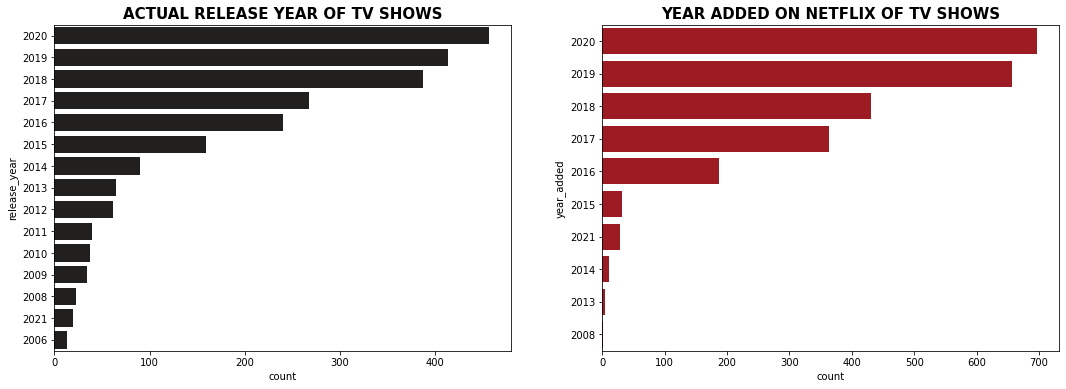

In [56]:
# plotting actual and netflix added year for tv show part
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.countplot(y="release_year", data=tv_show_df, color="#221f1f", order=tv_show_df['release_year'].value_counts().index[0:15])
plt.title('ACTUAL RELEASE YEAR OF TV SHOWS', fontsize=15, fontweight='bold')

plt.subplot(1,2,2)
sns.countplot(y="year_added", data=tv_show_df, color="#b20710", order=tv_show_df['year_added'].value_counts().index[0:15])
plt.title('YEAR ADDED ON NETFLIX OF TV SHOWS', fontsize=15, fontweight='bold')

* Year 2020 and 2019 has the maximum count in release year for Movie slice
* Year 2020 and 2019 has the maximum count in year added by netflix for tv show slice

### Analysis On Release Year And Date Added Together

Text(0.5, 1.0, 'ANALYSIS OF TV SHOW RELEASE YEAR AND YEAR ADDED ON NETFLIX')

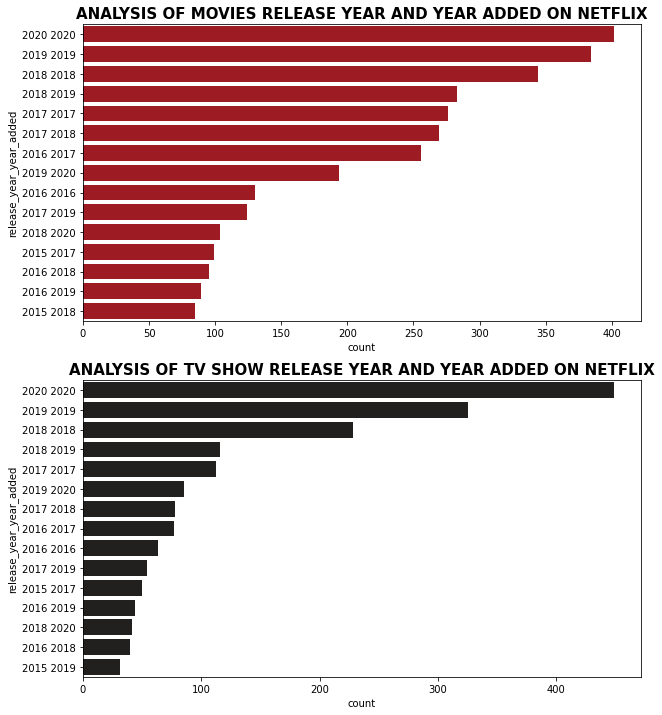

In [57]:
# ANALYSIS OF TOP 15 MOVIES AND TVSHOWS COUNTS WITH SIMILAR RELEASE YEAR AND DATE ADDED ON NETFLIX
movie_df["release_year_year_added"] = movie_df["release_year"].astype(str) +" " + movie_df["year_added"].astype(str)
tv_show_df["release_year_year_added"] = tv_show_df["release_year"].astype(str) +" " + tv_show_df["year_added"].astype(str)

fig = plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.countplot(data = movie_df,y = 'release_year_year_added', order = movie_df["release_year_year_added"].value_counts().index[:15],
              color='#b20710')
plt.title("ANALYSIS OF MOVIES RELEASE YEAR AND YEAR ADDED ON NETFLIX", fontsize=15, fontweight='bold')

plt.subplot(2,1,2)
sns.countplot(data = tv_show_df,y = 'release_year_year_added', order = tv_show_df["release_year_year_added"].value_counts().index[:15],
              color='#221f1f')
plt.title("ANALYSIS OF TV SHOW RELEASE YEAR AND YEAR ADDED ON NETFLIX", fontsize=15, fontweight='bold')

* In the above movie plot we can see that in the year 2020,2019,2018 has the most count above 350


* In the above tv show plot we can see that in the year 2020,2019,2018 has the most count above 200


* The above plot is to interpret that if the movie has both released and added on netflix in the same year or not, so only few of the contents (movies and tv_shows) are released and added on the same year which means it might be **NETFLIX ORIGINAL**

In [58]:
# Splitting movie and tv show data
tv_show_df = df[df["type"]=="tv show"]
movie_df = df[df["type"]=="movie"]

### Distribution Of Movie Runtime

Text(0.5, 1.0, 'Distribution Of Movie Runtime')

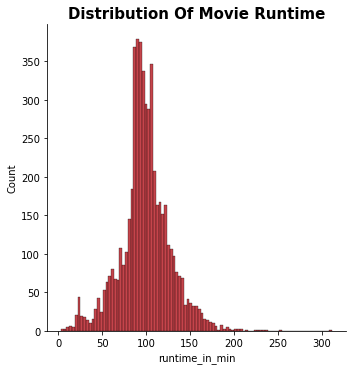

In [59]:
# plotting movie runtime using distplot
sns.displot(data=movie_df,x='runtime_in_min',color='#b20710')
plt.title("Distribution Of Movie Runtime", fontsize=15, fontweight='bold')


* Top most runtime in movie is 90 minutes with 370 count
* Most of the movie runtime is within its mean between 80-120 minutes



### Distribution Of Tv Show Runtime Per Episode

Text(0.5, 1.0, 'Distribution Of Tv Show Runtime')

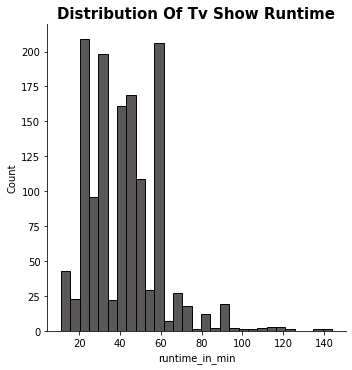

In [60]:
# plotting Tv Show runtime Per Episode using distplot
tv_show_df_runtime = tv_show_df.loc[(tv_show_df["runtime_in_min"] > 10) & (tv_show_df["runtime_in_min"] <=180)]
sns.displot(data=tv_show_df_runtime,x='runtime_in_min',color='#221f1f')
plt.title("Distribution Of Tv Show Runtime", fontsize=15, fontweight='bold')

* Above runtime per episode also had few datas above 300 minutes, so after bucketing them from 10 to 180 mins, we're able to visualize the above plot more clearly
* 25 and 60 minutes per episode have the top counts above 200
where as 35 minutes per episode have the count of 190

* Also we can see tv shows with duration 140 mins at max, which might be Documentaries


### Tv Shows And Their Season Counts

In [61]:
# value_counts of all tv_shows and their seasons 
tv_show_df["duration"].value_counts()

1 Season      1608
2 Seasons      382
3 Seasons      184
4 Seasons       87
5 Seasons       58
6 Seasons       30
7 Seasons       19
8 Seasons       18
9 Seasons        8
10 Seasons       6
11 Seasons       3
13 Seasons       2
12 Seasons       2
15 Seasons       2
16 Seasons       1
Name: duration, dtype: int64

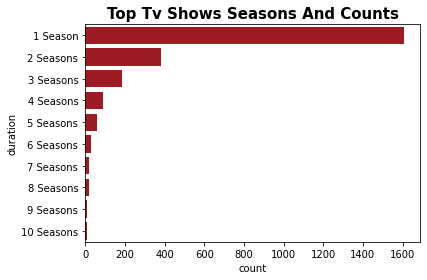

In [62]:
# plotting top 10 counts by seasons
sns.countplot(data = tv_show_df,y = 'duration', order = tv_show_df["duration"].value_counts().index[:10],color='#b20710')
plt.title("Top Tv Shows Seasons And Counts", fontsize=15, fontweight='bold')
plt.show()

* About 1600 tv shows only have one season 
* Tv shows with two seasons have a count almost 400

### Top Directors By Number Of Titles

In [63]:
# Creating a variable and exploding to find the top most directors(including all directors like assistant directors also)

filtered_directors = df[df["director"] != "No Data"]
filtered_directors = filtered_directors["director"].str.split(", ")
filtered_directors = filtered_directors.explode("director")
filtered_directors.value_counts()[:10]

Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Jay Chapman            12
Youssef Chahine        12
Martin Scorsese        12
Steven Spielberg       10
Shannon Hartman         9
Name: director, dtype: int64

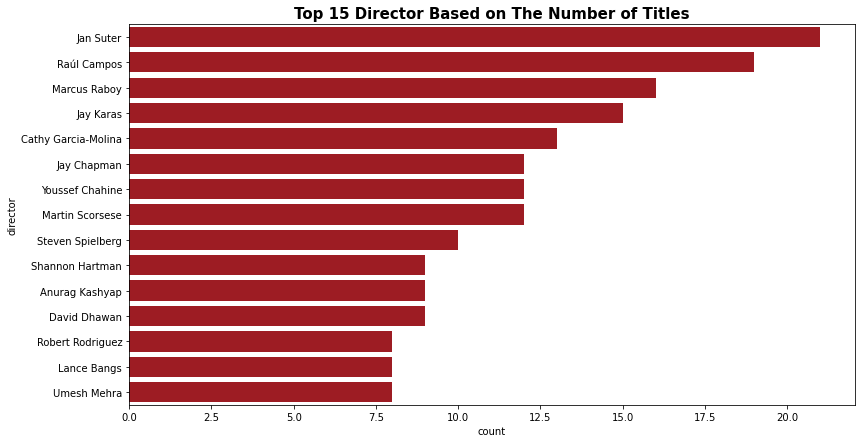

In [64]:
# plotting top 15 Directors by title number
plt.figure(figsize=(13,7))
plt.title('Top 15 Director Based on The Number of Titles', fontsize=15, fontweight='bold')
sns.countplot(y = filtered_directors, order=filtered_directors.value_counts().index[:15],color='#b20710')
plt.show()



*   Jan Suter and Raúl Campos has the top most directions with 21 and 19 counts

This plot is w.r.t whole data lets split movie and tv show and plot them



### Top 5 Tv Show Directors By Number Of Titles

In [65]:
tv_show_df = df[df["type"]=="tv show"]
movie_df = df[df["type"]=="movie"]

In [66]:
# Creating a variable and exploding to find the top most directors(including all directors like assistant directors also)
filtered_tvshow_directors = tv_show_df[tv_show_df["director"] != "No Data"]
filtered_tvshow_directors = filtered_tvshow_directors["director"].str.split(", ")
filtered_tvshow_directors = filtered_tvshow_directors.explode("director")

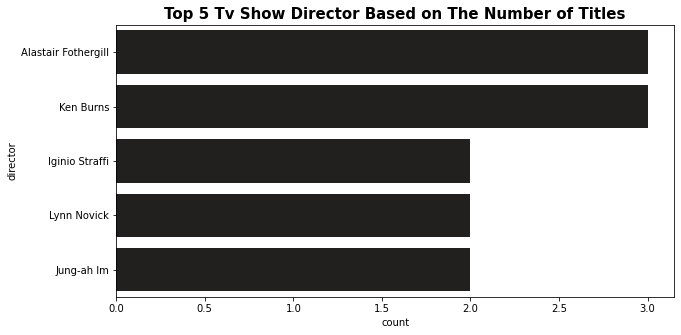

In [67]:
# plotting top 5 Directors by title number
plt.figure(figsize=(10,5))
plt.title('Top 5 Tv Show Director Based on The Number of Titles', fontsize=15, fontweight='bold')
sns.countplot(y = filtered_tvshow_directors, order=filtered_tvshow_directors.value_counts().index[:5], color='#221f1f')
plt.show()



*   Alastair Fothergill and Ken Burns have the top counts of 3 tv show directions
*   Maximum Count is 3 Directions in tv show



### Top 5 Movie Directors By Number Of Titles

In [68]:
# Creating a variable and exploding to find the top most directors
filtered_movie_directors = movie_df[movie_df["director"] != "No Data"]
filtered_movie_directors = filtered_movie_directors["director"].str.split(", ")
filtered_movie_directors = filtered_movie_directors.explode("director")

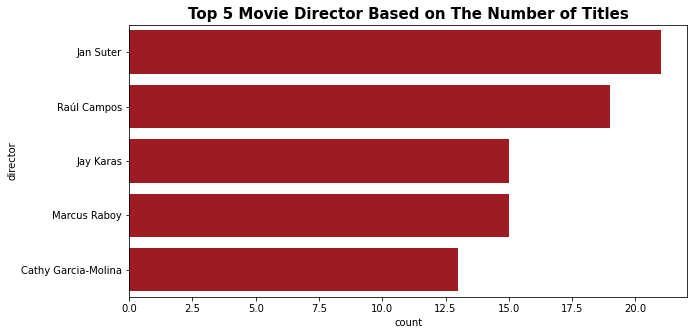

In [69]:
# plotting top 5 Directors by title number
plt.figure(figsize=(10,5))
plt.title('Top 5 Movie Director Based on The Number of Titles', fontsize=15, fontweight='bold')
sns.countplot(y = filtered_movie_directors, order=filtered_movie_directors.value_counts().index[:5], color='#b20710')
plt.show()

*   Jan Suter and Raul Campos have the top counts of 21 and 19 movie directions
*   Maximum Count is 21 Directions in movie

We can clearly see that tv show has only top count with 3 directions whereas movie with 21 count directions 

Let's check null values in both tv show, movie and make some analysis

### Checking Null Values For Directors In Tv Show And Movies

In [70]:
# Creating a column "null_value" 1 means null value and 0 means has data in it
tv_show_df["null_value"] = tv_show_df["director"].apply(lambda x: 1 if x== "No Data" else 0)
tv_show_df["null_value"].value_counts()

1    2226
0     184
Name: null_value, dtype: int64

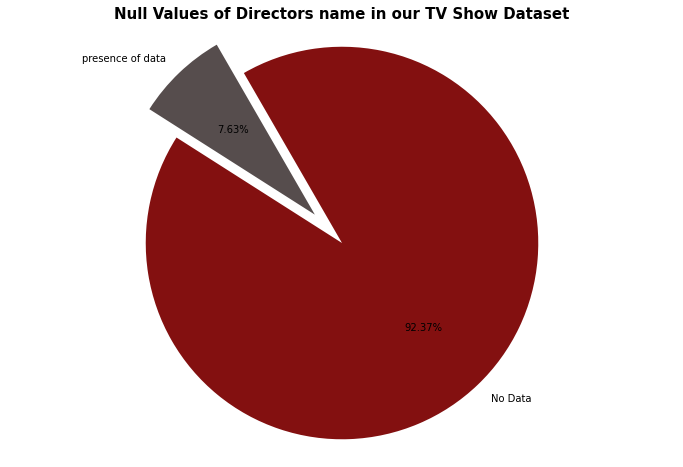

In [71]:
# plotting Pie Chart for Null values in Tv show datset
plt.figure(figsize=(12, 8))
labels=['presence of data', 'No Data']
plt.pie(tv_show_df["null_value"].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['#564d4d','#831010'], startangle=120)
plt.title('Null Values of Directors name in our TV Show Dataset', fontsize=15, fontweight='bold')
plt.axis('equal')
plt.show()

* In tv show dataset 92% of the directors name is missing
* So this was the reason, we only had 3 counts in top repeated director in tv show split

In [72]:
# Creating a column "null_value" 1 means null value and 0 means has data in it
movie_df["null_value"] = movie_df["director"].apply(lambda x: 1 if x== "No Data" else 0)
movie_df["null_value"].value_counts()

0    5214
1     163
Name: null_value, dtype: int64

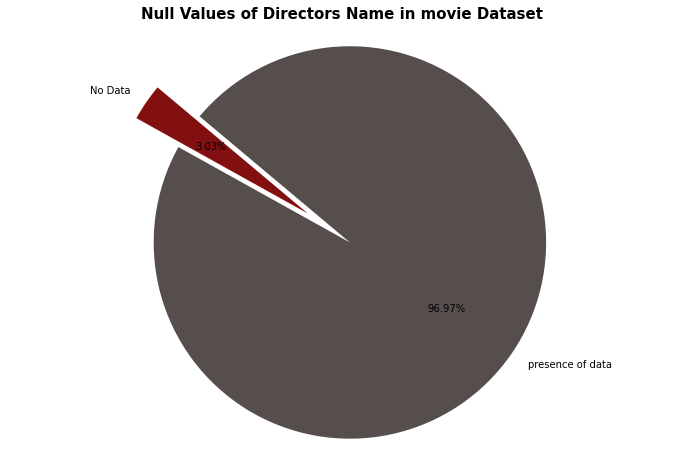

In [73]:
# plotting Pie Chart for Null values in Movie datset
plt.figure(figsize=(12, 8))
labels=['No Data','presence of data']
plt.pie(movie_df["null_value"].value_counts().sort_values(),labels=labels,explode=[0.13,0.13],
        autopct='%1.2f%%',colors=['#831010','#564d4d'], startangle=140)
plt.title('Null Values of Directors Name in movie Dataset', fontsize=15, fontweight='bold')
plt.axis('equal')
plt.show()

* Movie split has only 3 % null values 
* This was the reason, in the above top 15 directors of both tv show and movie had only top counts with movie director

Since we have more missing values in tv show split , lets just make analysis based on top movie directors keeping a threshold i.e, above 8 imdb rating as good movies and interpreting them through DataFrames

### Top Movie Directors By Average IMDB Rating

In [74]:
# setting a threshold of rating above 8 as good movies 
movie_directors = movie_df[(movie_df["director"] != "No Data") & (movie_df["averageRating"]>= 8)]
movie_directors["director"] = movie_directors["director"].str.split(", ")
movie_director = movie_directors.explode("director")


In [75]:
# Top 10 Movie directors with top IMDB rating
movie_dir_top_rate = movie_director.groupby("director")["averageRating"].max().sort_values(ascending=False)
movie_dir_top_rate[:10].to_frame()

,averageRating
director,
Antongiulio Panizzi,9.2
Harald Zwart,9.1
Steven Spielberg,9.0
Tilak Shetty,9.0
Peter Jackson,9.0
Robert O. Peters,9.0
Jayaprakash Radhakrishnan,9.0
Samir Al Asfory,9.0
Quentin Tarantino,8.9


Since most of the director name is not present in tv show we'll just see top directors in movie split with good movies(Above 8 imdb rating) and thier counts

In [76]:
# picking directors value_counts for getting top directors with most good movies (above 8 rating)
movie_director['director'].value_counts()[:5]

Quentin Tarantino       5
Martin Scorsese         5
Steven Spielberg        4
Christopher Storer      3
Hrishikesh Mukherjee    2
Name: director, dtype: int64

In [229]:
# top movie director with 5 good movies
top_directors = movie_director[["director","title","averageRating"]]
qt_df = top_directors[top_directors["director"]== "Quentin Tarantino"]
qt_df.sort_values("averageRating", ascending=False).reset_index(drop=True)


,director,title,averageRating
0,Quentin Tarantino,pulp fiction,8.9
1,Quentin Tarantino,django unchained,8.4
2,Quentin Tarantino,inglourious basterds,8.3
3,Quentin Tarantino,kill bill: vol. 1,8.2
4,Quentin Tarantino,kill bill: vol. 2,8.0


* Top rated movie by the above director is "pulp fiction" and "django unchained" witth 8.9 and 8.4 rating
* Django unchained in one of my liked movies with action and carnage genres 

In [78]:
# top movie director with 5 good movie
ms_df = top_directors[top_directors["director"]== "Martin Scorsese"]
ms_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Martin Scorsese,goodfellas,8.7
1,Martin Scorsese,the departed,8.5
2,Martin Scorsese,no direction home: bob dylan,8.4
3,Martin Scorsese,raging bull,8.2
4,Martin Scorsese,taxi driver,8.2


* Top rated movie by the above director is "goodfellas" and "the departed" with 8.7 and 8.5 rating
* The departed is based on a true story and it is also one of my favourite Crime based movie

In [79]:
# top movie director with 4 good movie
ss_df = top_directors[top_directors["director"]== "Steven Spielberg"]
ss_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Steven Spielberg,schindler's list,9.0
1,Steven Spielberg,indiana jones and the raiders of the lost ark,8.4
2,Steven Spielberg,indiana jones and the last crusade,8.2
3,Steven Spielberg,catch me if you can,8.1


* Top rated movie by the above director is "schindler's list" and "indiana jones and the raiders of the lost ark" with 9 and 8.4 rating

In [80]:
# top movie director with 3 good movie
cs_df = top_directors[top_directors["director"]== "Christopher Storer"]
cs_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Christopher Storer,bo burnham: make happy,8.3
1,Christopher Storer,bo burnham: what.,8.3
2,Christopher Storer,hasan minhaj: homecoming king,8.2


* Top rated movie by the above director is "bo burnham: make happy" and "bo burnham: what." with both 8.3 rating

In [81]:
# top movie director with 2 good movie
hm_df = top_directors[top_directors["director"]== "Hrishikesh Mukherjee"]
hm_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,director,title,averageRating
0,Hrishikesh Mukherjee,chupke chupke,8.3
1,Hrishikesh Mukherjee,bawarchi,8.1


* Top rated movie by the above director is "chupke chupke" and "bawarchi" with 8.3 and 8.1 rating

### Top Movie Directors By Maximum Number Of Votes

In [82]:
# Top 10 movie directors by max number of votes
top_director_and_title_by_numvotes = movie_df[["director","title","averageRating","numVotes"]]
top_director_and_title_by_numvotes = top_director_and_title_by_numvotes.sort_values(by="numVotes", ascending=False)
top_director_and_title_by_numvotes = top_director_and_title_by_numvotes.iloc[:10,:]
top_director_and_title_by_numvotes.reset_index(drop=True)

,director,title,averageRating,numVotes
0,Christopher Nolan,inception,8.8,2304473.0
1,Quentin Tarantino,pulp fiction,8.9,2011370.0
2,"Lilly Wachowski, Lana Wachowski",the matrix,8.7,1881722.0
3,Peter Jackson,the lord of the rings: the return of the king,9.0,1802007.0
4,Peter Jackson,the lord of the rings: the two towers,8.8,1627178.0
5,Quentin Tarantino,django unchained,8.4,1519911.0
6,Quentin Tarantino,inglourious basterds,8.3,1417579.0
7,Steven Spielberg,schindler's list,9.0,1333619.0
8,Martin Scorsese,the departed,8.5,1303717.0
9,Sam Mendes,american beauty,8.4,1141348.0


* Most voted movie is Inception in this dataset with 2304473 votes

### Top Tv Shows with Maximum Number Of Votes

In [83]:
# Top 10 Tv shows with max number of votes, Since director name is nill lets just drop it keeping top tv shows
top_tv_title_by_numvotes = tv_show_df[["title","averageRating","numVotes"]]
top_tv_title_by_numvotes = top_tv_title_by_numvotes.sort_values(by="numVotes", ascending=False)
top_tv_title_by_numvotes = top_tv_title_by_numvotes.iloc[:10,:]
top_tv_title_by_numvotes.reset_index(drop=True)

,title,averageRating,numVotes
0,breaking bad,9.5,1797781.0
1,stranger things,8.7,1124599.0
2,friends,8.9,970970.0
3,the walking dead,8.2,961435.0
4,sherlock,9.1,907225.0
5,dexter,8.7,718175.0
6,black mirror,8.8,530122.0
7,peaky blinders,8.8,519372.0
8,house of cards,8.7,498926.0
9,the witcher,8.2,475048.0


* Most voted Tv show is Breaking Bad in this dataset with 1797781 votes and this also my favourite tv show

### Top Movie Title And Rating With Null Directors 

In [84]:
# movie with top rating but absence of director name
null_movie_directors = movie_df[(movie_df["director"] == "No Data") & (movie_df["averageRating"]>= 8)]
title_rating_null__mov_dir = null_movie_directors[["title","averageRating"]]
title_rating_null__mov_dir = title_rating_null__mov_dir.sort_values("averageRating", ascending=False).reset_index(drop=True)
title_rating_null__mov_dir

,title,averageRating
0,one heart: the a.r. rahman concert film,8.5
1,disclosure,8.2
2,roll with me,8.2
3,beary tales,8.1
4,rising phoenix,8.1


### Top Tv Show Title And Rating With Null Directors 

In [85]:
# Tv shows with top imdb rating but absence of director name
null_tv_show_directors = tv_show_df[(tv_show_df["director"] == "No Data") & (tv_show_df["averageRating"]>= 8)]
title_rating_null_tv_dir = null_tv_show_directors[["title","averageRating"]]
title_rating_null_tv_dir = title_rating_null_tv_dir.sort_values("averageRating", ascending=False).reset_index(drop=True)
title_rating_null_tv_dir[:10]

,title,averageRating
0,warrior,9.8
1,scream,9.7
2,broken,9.7
3,requiem,9.5
4,breaking bad,9.5
5,immortals,9.4
6,winter sun,9.4
7,the ultimatum,9.3
8,the playbook,9.3
9,chosen,9.3


### Top Actors With Most Titles

In [86]:
# Manipulating cast column to explode every cast members and finding top actors with most no titles
filtered_actor = df[df["cast"] != "No Data"]
filtered_actor = filtered_actor["cast"].str.split(", ")
filtered_actor = filtered_actor.explode("cast")
filtered_actor.value_counts()[:10]

Anupam Kher         42
Shah Rukh Khan      35
Naseeruddin Shah    30
Om Puri             30
Akshay Kumar        29
Takahiro Sakurai    29
Amitabh Bachchan    27
Paresh Rawal        27
Yuki Kaji           27
Boman Irani         27
Name: cast, dtype: int64

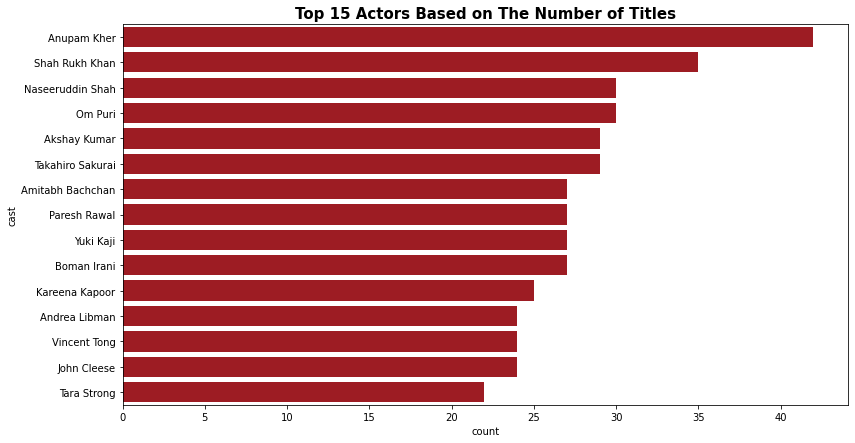

In [87]:
# plotting top 15 actors Based on The Number of Titles
plt.figure(figsize=(13,7))
plt.title('Top 15 Actors Based on The Number of Titles', fontsize=15, fontweight='bold')
plt.xlabel("Title Count")
plt.ylabel("Actors")
sns.countplot(y = filtered_actor, order=filtered_actor.value_counts().index[:15],color='#b20710')
plt.show()

* We can clearly see most of the top actors are indian cinema actors
* Anupam Kher has acted in the most number of the movies with 42 movies

### Top Tv Show Actors With Most Titles

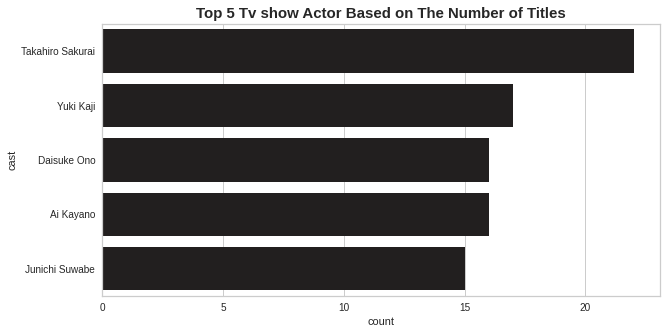

In [230]:
# Manipulating cast column to explode every cast members and finding top actors with most no titles(including all members in cast crew)

filtered_tvshow_actors = tv_show_df[tv_show_df["cast"] != "No Data"]
filtered_tvshow_actors = filtered_tvshow_actors["cast"].str.split(", ")
filtered_tvshow_actors = filtered_tvshow_actors.explode("cast")
# plotting top 5 actors in tv show
plt.figure(figsize=(10,5))
plt.title('Top 5 Tv show Actor Based on The Number of Titles', fontsize=15, fontweight='bold')
sns.countplot(y = filtered_tvshow_actors, order=filtered_tvshow_actors.value_counts().index[:5], color='#221f1f')
plt.show()

* Takahiro Sakurai is the top tv show actor based on number titles he has acted in (22 shows)

### Top Movie Actors With Most Titles

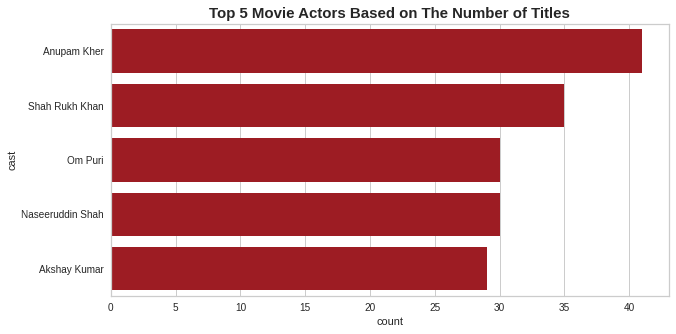

In [231]:
# Plotting top 5 movie actors
filtered_movie_actors = movie_df[movie_df["cast"] != "No Data"]
filtered_movie_actors = filtered_movie_actors["cast"].str.split(", ")
filtered_movie_actors = filtered_movie_actors.explode("cast")

plt.figure(figsize=(10,5))
plt.title('Top 5 Movie Actors Based on The Number of Titles', fontsize=15, fontweight='bold')
sns.countplot(y = filtered_movie_actors, order=filtered_movie_actors.value_counts().index[:5], color='#b20710')
plt.show()

In [236]:
# Splitting tv and movie actors and analysing top actors with good rating above 8
tv_actors = tv_show_df[(tv_show_df["cast"] != "No Data") & (tv_show_df["averageRating"]>= 8)]
tv_actors["cast"] = tv_actors["cast"].str.split(", ")
tv_actors = tv_actors.explode("cast")

movie_actors = movie_df[(movie_df["cast"] != "No Data") & (movie_df["averageRating"]>= 8)]
movie_actors["cast"] = movie_actors["cast"].str.split(", ")
movie_actors = movie_actors.explode("cast")


### Top Actors With Good Movie Rating

In [91]:
# value_counts of actors with good movie rating
movie_actors['cast'].value_counts()[:5]

Aamir Khan           5
Leonardo DiCaprio    5
Naseeruddin Shah     4
John Rhys-Davies     4
Ajay Devgn           4
Name: cast, dtype: int64

In [92]:
# 1st top actor with good movie rating and their titles
top_actors = movie_actors[["cast","title","averageRating"]]
ldc_df = top_actors[top_actors["cast"]== "Leonardo DiCaprio"]
ldc_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Leonardo DiCaprio,inception,8.8
1,Leonardo DiCaprio,the departed,8.5
2,Leonardo DiCaprio,django unchained,8.4
3,Leonardo DiCaprio,before the flood,8.2
4,Leonardo DiCaprio,catch me if you can,8.1


In [93]:
# 2nd top actor with good movie rating and their titles
ak_df = top_actors[top_actors["cast"]== "Aamir Khan"]
ak_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Aamir Khan,3 idiots,8.4
1,Aamir Khan,dangal,8.3
2,Aamir Khan,dil chahta hai,8.1
3,Aamir Khan,pk,8.1
4,Aamir Khan,andaz apna apna,8.0


In [94]:
# 3rd top actor with good movie rating and their titles
ns_df = top_actors[top_actors["cast"]== "Naseeruddin Shah"]
ns_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Naseeruddin Shah,masoom,8.4
1,Naseeruddin Shah,peepli live,8.3
2,Naseeruddin Shah,zindagi na milegi dobara,8.2
3,Naseeruddin Shah,a wednesday,8.1


In [95]:
# 4th top actor with good movie rating and their titles
jrd_df = top_actors[top_actors["cast"]== "John Rhys-Davies"]
jrd_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,John Rhys-Davies,the lord of the rings: the return of the king,9.0
1,John Rhys-Davies,the lord of the rings: the two towers,8.8
2,John Rhys-Davies,indiana jones and the raiders of the lost ark,8.4
3,John Rhys-Davies,indiana jones and the last crusade,8.2


In [96]:
# 5th top actor with good movie rating and their titles
ad_df = top_actors[top_actors["cast"]== "Ajay Devgn"]
ad_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Ajay Devgn,mahabharat,8.9
1,Ajay Devgn,drishyam,8.2
2,Ajay Devgn,the legend of bhagat singh,8.1
3,Ajay Devgn,company,8.0


### Top Actors With Good Tv Show Rating

In [97]:
# value_counts of actors with good tvshow rating
tv_actors['cast'].value_counts()[:5]

Hiroshi Kamiya      5
Yuki Kaji           5
Yoshimasa Hosoya    5
Shinichiro Miki     4
Hiroyuki Yoshino    4
Name: cast, dtype: int64

In [98]:
# 1st top actor with good tv show rating and their titles
top_actors_tv = tv_actors[["cast","title","averageRating"]]
hk_df = top_actors_tv[top_actors_tv["cast"]== "Hiroshi Kamiya"]
hk_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Hiroshi Kamiya,attack on titan,9.0
1,Hiroshi Kamiya,haikyu!!,8.7
2,Hiroshi Kamiya,the disastrous life of saiki k.,8.4
3,Hiroshi Kamiya,kuroko's basketball,8.3
4,Hiroshi Kamiya,fate/stay night: unlimited blade works,8.0


In [99]:
# 2nd top actor with good tv show rating and their titles
yk_df = top_actors_tv[top_actors_tv["cast"]== "Yuki Kaji"]
yk_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Yuki Kaji,attack on titan,9.0
1,Yuki Kaji,haikyu!!,8.7
2,Yuki Kaji,your lie in april,8.6
3,Yuki Kaji,jojo's bizarre adventure,8.4
4,Yuki Kaji,dorohedoro,8.1


In [100]:
# 3rd top actor with good tv show rating and their titles
yh_df = top_actors_tv[top_actors_tv["cast"]== "Yoshimasa Hosoya"]
yh_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Yoshimasa Hosoya,attack on titan,9.0
1,Yoshimasa Hosoya,haikyu!!,8.7
2,Yoshimasa Hosoya,kuroko's basketball,8.3
3,Yoshimasa Hosoya,march comes in like a lion,8.3
4,Yoshimasa Hosoya,dorohedoro,8.1


In [101]:
# 4th top actor with good tv show rating and their titles
sm_df = top_actors_tv[top_actors_tv["cast"]== "Shinichiro Miki"]
sm_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Shinichiro Miki,fullmetal alchemist: brotherhood,9.1
1,Shinichiro Miki,march comes in like a lion,8.3
2,Shinichiro Miki,dorohedoro,8.1
3,Shinichiro Miki,fate/stay night: unlimited blade works,8.0


In [102]:
# 5th top actor with good tv show rating and their titles
hy_df = top_actors_tv[top_actors_tv["cast"]== "Hiroyuki Yoshino"]
hy_df.sort_values("averageRating", ascending=False).reset_index(drop=True)

,cast,title,averageRating
0,Hiroyuki Yoshino,fullmetal alchemist: brotherhood,9.1
1,Hiroyuki Yoshino,haikyu!!,8.7
2,Hiroyuki Yoshino,parasyte: the maxim,8.3
3,Hiroyuki Yoshino,toradora!,8.0


The Top actors in the above tv show are voice actors, since we wanted to pick consistent actors with good rating, we found that the above are voice actors with many tv shows and good rating, most of the above tv shows are anime series

### Top Main Lead Actor with Highest Number Of Votes

In [103]:
# top main lead actor with highest number of votes
top_actor_and_title_by_numvotes = movie_df[["cast","title","averageRating","numVotes"]]
top_actor_and_title_by_numvotes = top_actor_and_title_by_numvotes.sort_values(by="numVotes", ascending=False).iloc[:10,:]
top_actor_and_title_by_numvotes["main_lead"] = top_actor_and_title_by_numvotes["cast"].apply(lambda x: x.split(", ")[0])
top_actor_and_title_by_numvotes = top_actor_and_title_by_numvotes.drop(["cast"],axis = 1)
top_actor_and_title_by_numvotes.reset_index(drop=True)

,title,averageRating,numVotes,main_lead
0,inception,8.8,2304473.0,Leonardo DiCaprio
1,pulp fiction,8.9,2011370.0,John Travolta
2,the matrix,8.7,1881722.0,Keanu Reeves
3,the lord of the rings: the return of the king,9.0,1802007.0,Elijah Wood
4,the lord of the rings: the two towers,8.8,1627178.0,Elijah Wood
5,django unchained,8.4,1519911.0,Jamie Foxx
6,inglourious basterds,8.3,1417579.0,Brad Pitt
7,schindler's list,9.0,1333619.0,Liam Neeson
8,the departed,8.5,1303717.0,Leonardo DiCaprio
9,american beauty,8.4,1141348.0,Kevin Spacey


Since we cant say main lead for few tv shows which may have 3 or more main lead ex: friends tv show, we'll just see all cast crew in that top voted tv show

In [104]:
# top voted tv shows and their cast crew
top_tv_title_by_numvotes = tv_show_df[["cast","title","averageRating","numVotes"]]
top_tv_title_by_numvotes = top_tv_title_by_numvotes.sort_values(by="numVotes", ascending=False)
top_tv_title_by_numvotes = top_tv_title_by_numvotes.iloc[:10,:]
top_tv_title_by_numvotes.reset_index(drop=True)

,cast,title,averageRating,numVotes
0,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",breaking bad,9.5,1797781.0
1,"Winona Ryder, David Harbour, Finn Wolfhard, Mi...",stranger things,8.7,1124599.0
2,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",friends,8.9,970970.0
3,"Andrew Lincoln, Steven Yeun, Norman Reedus, Ch...",the walking dead,8.2,961435.0
4,"Benedict Cumberbatch, Martin Freeman, Una Stub...",sherlock,9.1,907225.0
5,"Michael C. Hall, Jennifer Carpenter, David Zay...",dexter,8.7,718175.0
6,"Jesse Plemons, Cristin Milioti, Jimmi Simpson,...",black mirror,8.8,530122.0
7,"Cillian Murphy, Sam Neill, Helen McCrory, Paul...",peaky blinders,8.8,519372.0
8,"Kevin Spacey, Robin Wright, Kate Mara, Corey S...",house of cards,8.7,498926.0
9,"Henry Cavill, Anya Chalotra, Freya Allan, Jodh...",the witcher,8.2,475048.0


### Top 10 Rated Movie With Missing Cast Crew Names

In [105]:
# displaying most rated actor's movie title and rating with absence of their data
null_movie_actors = movie_df[(movie_df["cast"] == "No Data") & (movie_df["averageRating"]>= 8)]
title_rating_null__mov_act = null_movie_actors[["title","averageRating"]]
title_rating_null__mov_act = title_rating_null__mov_act.sort_values("averageRating", ascending=False).reset_index(drop=True)
title_rating_null__mov_act[:10]


,title,averageRating
0,woodstock,8.8
1,unbroken,8.6
2,life in the doghouse,8.4
3,martyrs of marriage,8.3
4,winter on fire: ukraine's fight for freedom,8.3
5,the look of silence,8.3
6,rush: beyond the lighted stage,8.3
7,virunga,8.2
8,roll with me,8.2
9,13th,8.2


* Woodstock and unbroken are the movie titles with highest rating where cast crew data is missing

### Top 10 Rated Tv Show With Missing Cast Crew Names

In [106]:
# displaying most rated actor's tv_show title and rating with absence of their data
null_tv_show_act = tv_show_df[(tv_show_df["cast"] == "No Data") & (tv_show_df["averageRating"]>= 8)]
title_rating_null_tv_act = null_tv_show_act[["title","averageRating"]]
title_rating_null_tv_act = title_rating_null_tv_act.sort_values("averageRating", ascending=False).reset_index(drop=True)
title_rating_null_tv_act[:10]

,title,averageRating
0,broken,9.7
1,the playbook,9.3
2,high score,9.1
3,edge of the universe,8.8
4,the repair shop,8.7
5,stories by rabindranath tagore,8.7
6,haunted,8.7
7,lenox hill,8.6
8,the calling,8.6
9,regiment diaries,8.6


Broken and The Playbook is the highest rated Tv Show titles where cast crew data is missing

# 2. Understanding what type content is available in different countries

In [108]:
# Splitting and exploding country column to get the top 6 countries
filtered_countries = df["country"].str.split(", ")
filtered_countries = filtered_countries.explode("country")

In [111]:
# Splitting and exploding both country and listed_in columns for betterment in counts
explode_df =  df[["title","country","listed_in","rating"]]
explode_df["country"] = explode_df["country"].str.split(", ")
explode_df["listed_in"] = explode_df["listed_in"].str.split(", ")
explode_df = explode_df.explode("country")
explode_df = explode_df.explode("listed_in")

### 2.1 Plotting Top 6 Countries And Their Genres

In [112]:
# creating a list which contains top 6 countries by order for plotting them in a loop
lst = ['United States',	'India',	'United Kingdom','Canada','France',	'Japan']

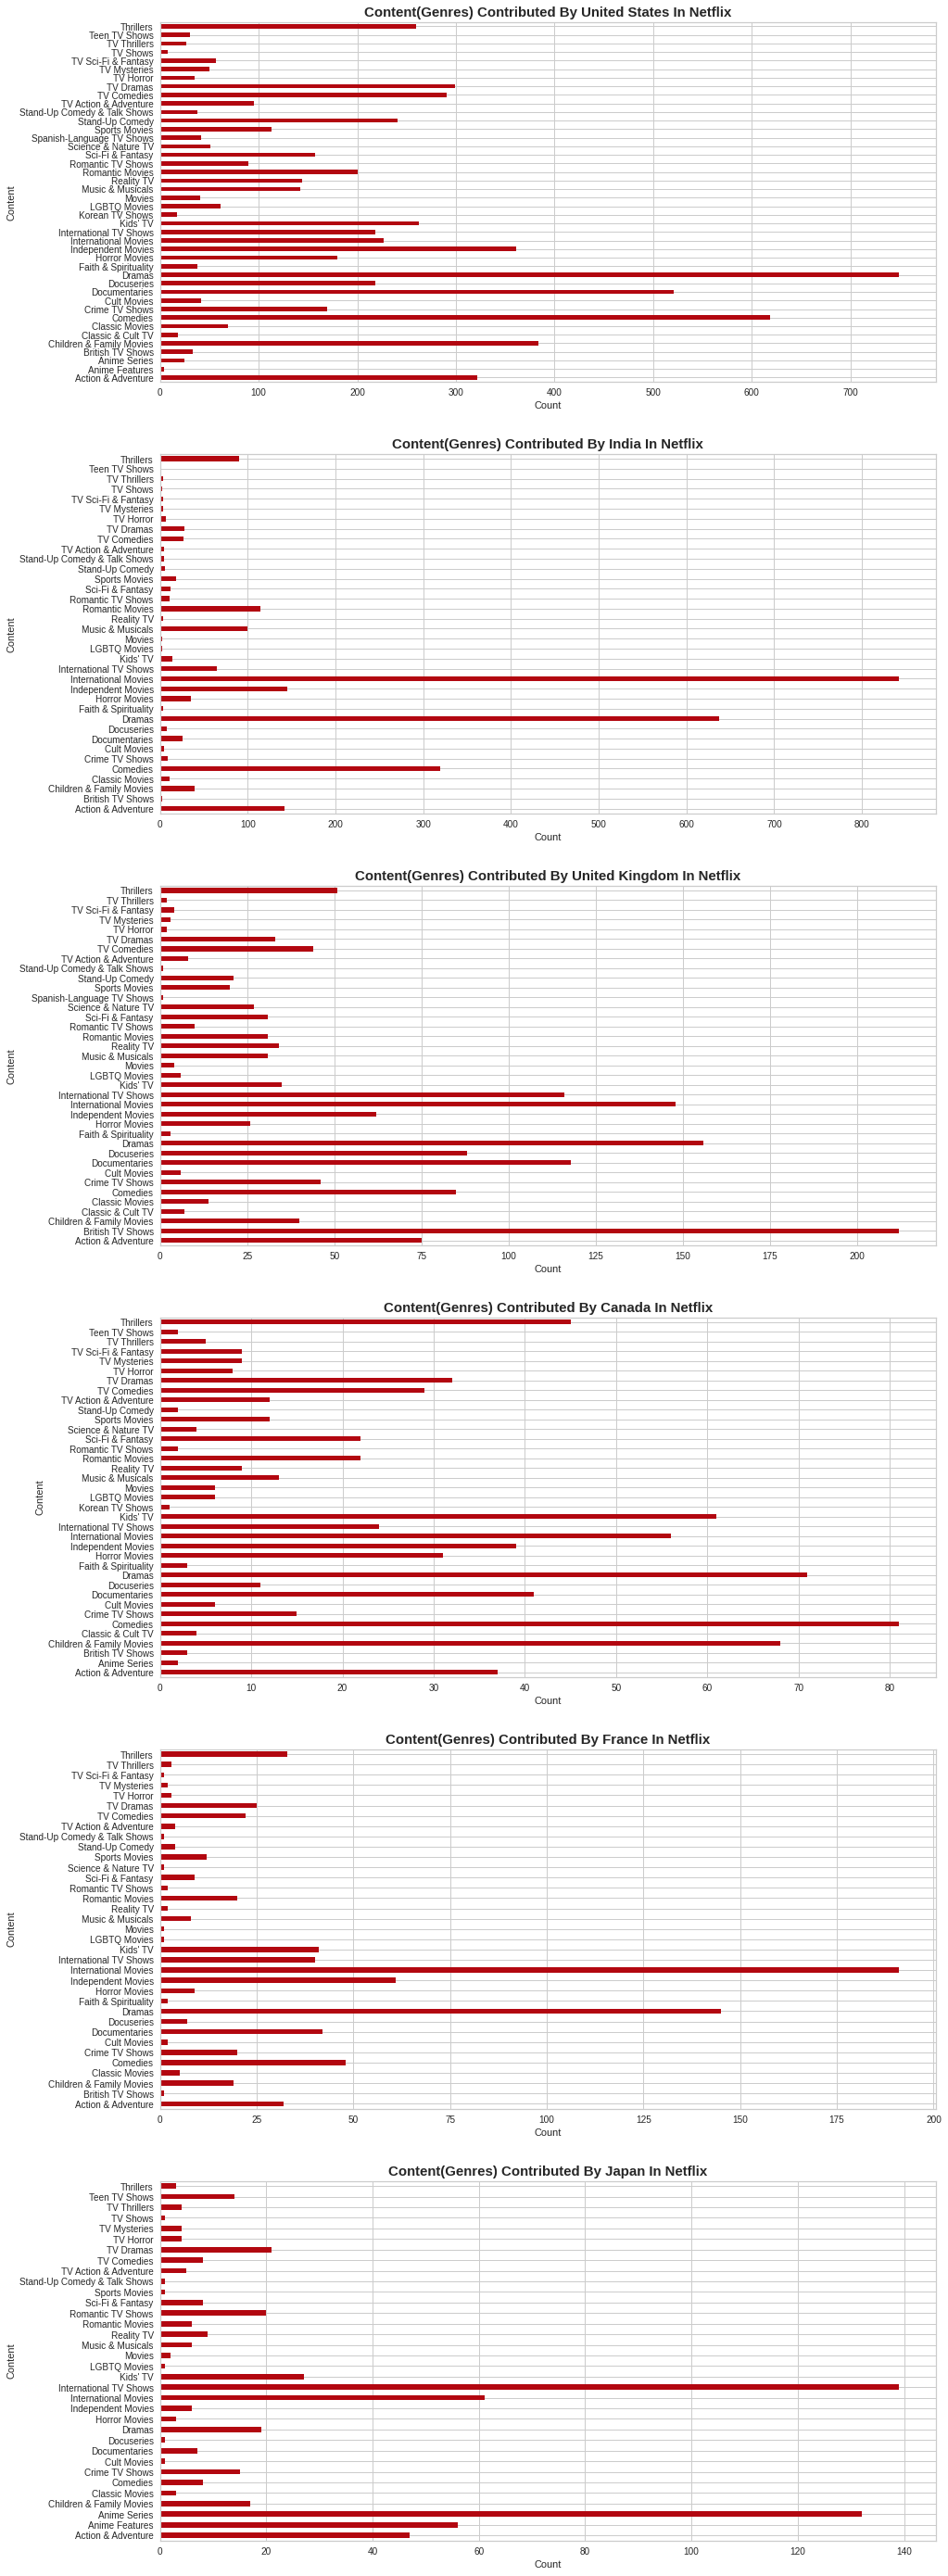

In [238]:
# Plotting top 6 countries most choosen genres
i=0
plt.figure(figsize=(15, 50))
for country_name in lst:
  country_list = []
  country_list = explode_df.loc[explode_df["country"]== country_name]
  plt.subplot(6,1,i+1)
  country_list.groupby(["listed_in"])["listed_in"].count().plot(kind="barh",color='#b20710')
  plt.title(f"Content(Genres) Contributed By {country_name} In Netflix", fontsize=15, fontweight='bold')
  plt.ylabel("Content")
  plt.xlabel("Count")
  i+=1

* United States have contributed in genre **Dramas** the most
* India has contributed in **International Movies** the most
* United Kingdom has contributed more in **British Tv Show**
* Canada have contributed more in **Comidies** Genre
* France has also contributed in **International Movies** the most 
* Japan has contributed more in **International Tv Shows**

### 2.2 Plotting Top 6 Countries And Their Rating

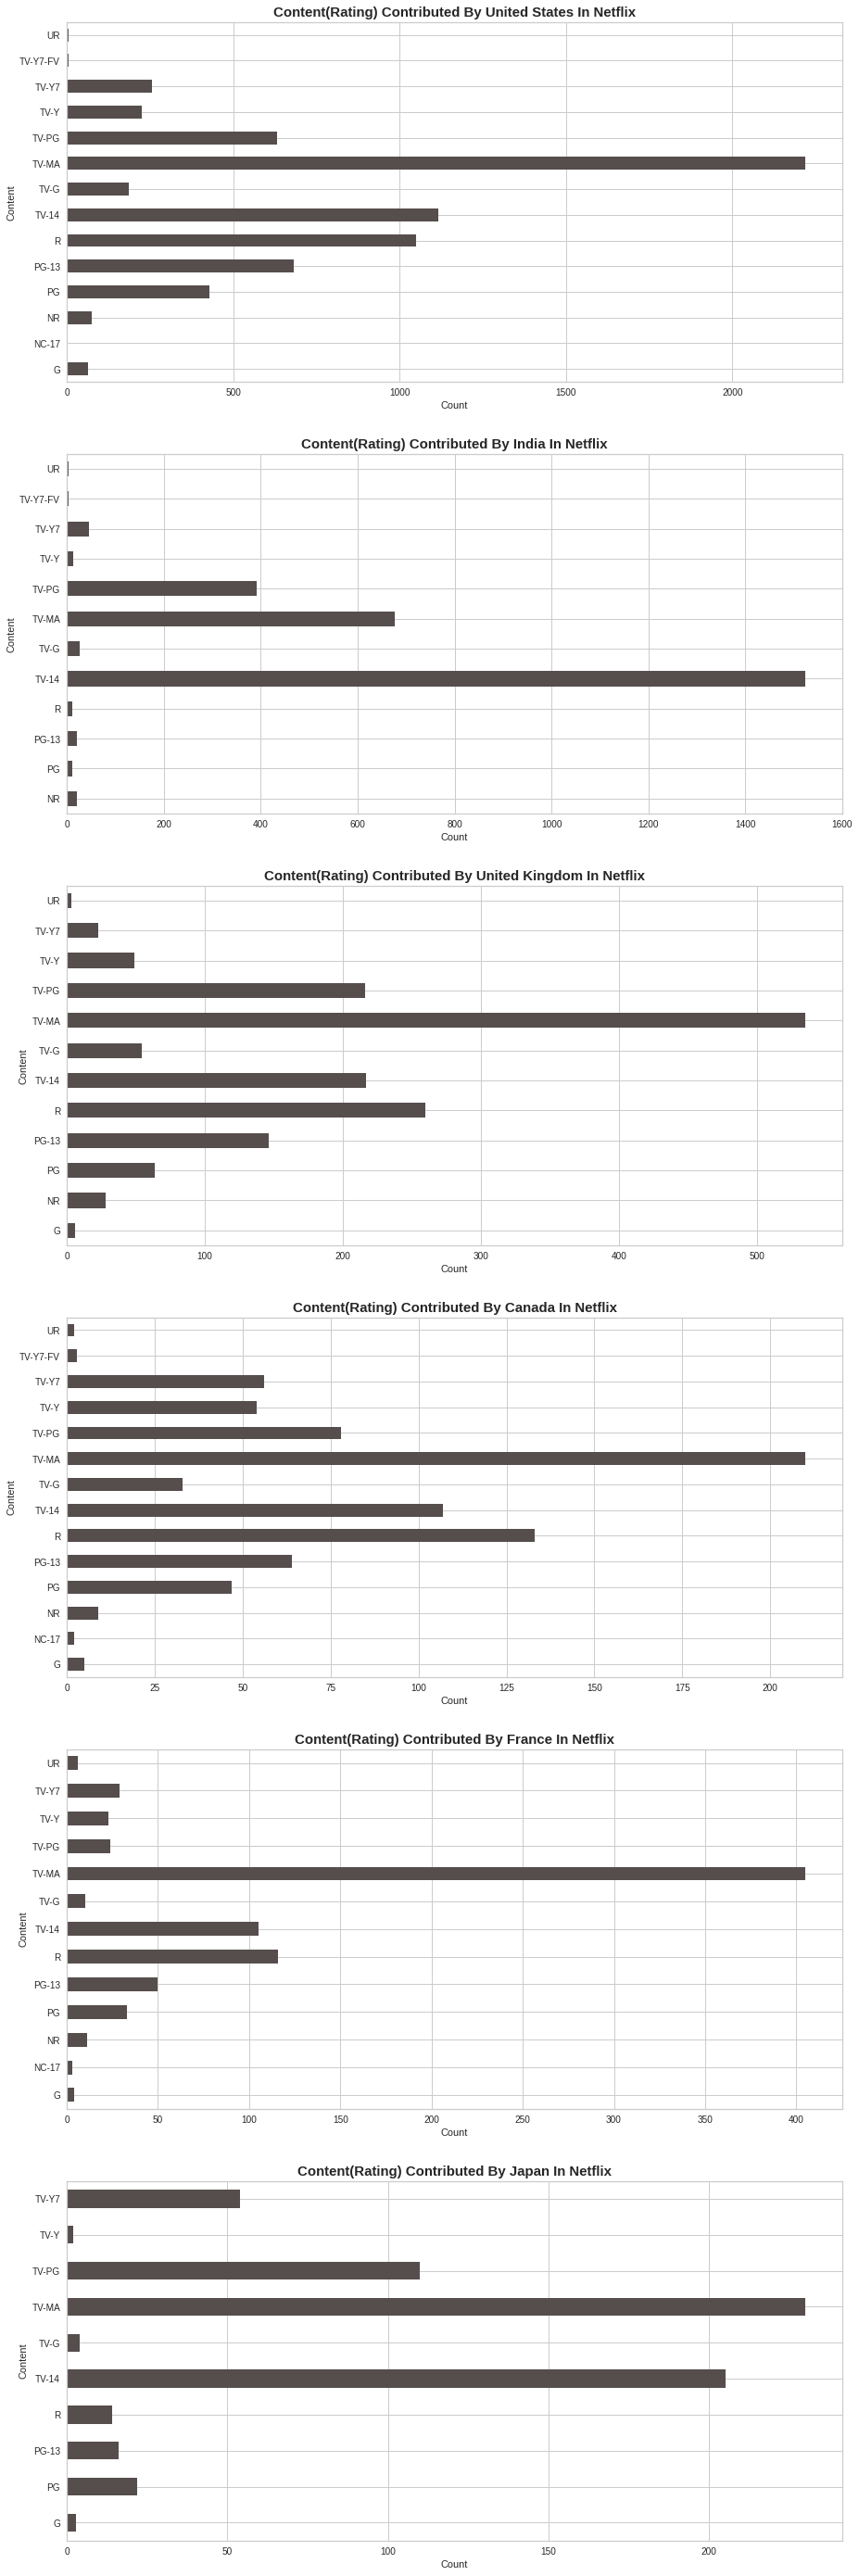

In [239]:
# Plotting top 6 countries most choosen rating
i=0
plt.figure(figsize=(15, 50))
for country_name in lst:
  country_list = []
  country_list = explode_df.loc[explode_df["country"]== country_name]
  plt.subplot(6,1,i+1)
  country_list.groupby(["rating"])["rating"].count().plot(kind="barh",color='#564d4d')
  plt.title(f"Content(Rating) Contributed By {country_name} In Netflix", fontsize=15, fontweight='bold')
  plt.ylabel("Content")
  plt.xlabel("Count")
  i+=1

* All the top 6 countries expect India have more content based on TV-MA which is for mature audience
* India has more content based on TV-14 which is for teen audience

# 3. Is Netflix has increasingly focusing on TV rather than movies in recent years.

In [117]:
netflix_year_df = df.year_added.value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})
movies_year_df = movie_df.year_added.value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})
tv_shows_year_df = tv_show_df.year_added.value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})

In [240]:
netflix_year_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
year,2019,2020,2018,2017,2016,2021,2015,2014,2011,2013,2012,2008,2009,2010
count,2153,2009,1685,1227,445,117,90,29,13,11,3,2,2,1


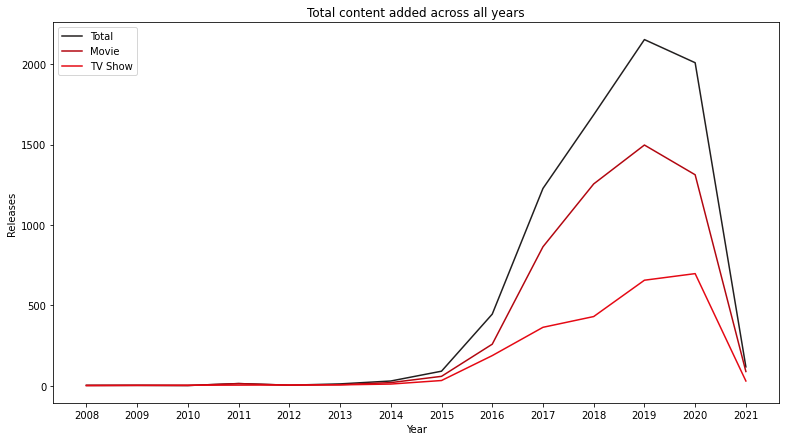

In [119]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=netflix_year_df, x='year', y='count')
sns.lineplot(data=movies_year_df, x='year', y='count')
sns.lineplot(data=tv_shows_year_df, x='year', y='count')
ax.set_xticks(np.arange(2008, 2022, 1))
plt.title("Total content added across all years")
plt.legend(['Total','Movie','TV Show'])
plt.ylabel("Releases")
plt.xlabel("Year")
plt.show()

* The growth in number of movies on netflix is much higher than that of TV shows
* About 1200 new movies were added in both 2018 and 2019
* The growth in content started from 2013
* It stated falling from the year 2020

In [121]:
# Creating total, movies and tv_show dataframes with counts
netflix_month_df = df.month.value_counts().to_frame().reset_index().rename(columns={"index": "month", "month":"count"})
movies_month_df = movie_df.month.value_counts().to_frame().reset_index().rename(columns={"index": "month", "month":"count"})
tv_shows_month_df = tv_show_df.month.value_counts().to_frame().reset_index().rename(columns={"index": "month", "month":"count"})

In [122]:
# Creating new column as month numbers for plotting purpose
netflix_month_df["month_no"] = netflix_month_df["month"].map({"January":0,"February":1,"March":2,"April":3,"May":4,"June":5,
                                                                "July":6,"August":7,"September":8,"October":9,"November":10,"December":11})
netflix_month_df = netflix_month_df.set_index("month_no").sort_index()

In [123]:
# Creating new column as month numbers for plotting purpose
movies_month_df["month_no"] = movies_month_df["month"].map({"January":0,"February":1,"March":2,"April":3,"May":4,"June":5,
                                                                "July":6,"August":7,"September":8,"October":9,"November":10,"December":11})
movies_month_df = movies_month_df.set_index("month_no").sort_index()

In [124]:
# Creating new column as month numbers for plotting purpose
tv_shows_month_df["month_no"] = tv_shows_month_df["month"].map({"January":0,"February":1,"March":2,"April":3,"May":4,"June":5,
                                                                "July":6,"August":7,"September":8,"October":9,"November":10,"December":11})
tv_shows_month_df = tv_shows_month_df.set_index("month_no").sort_index()

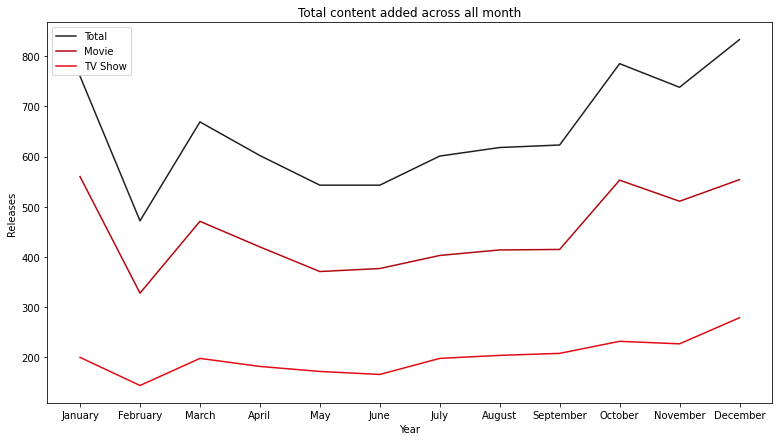

In [125]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=netflix_month_df, x='month', y='count')
sns.lineplot(data=movies_month_df, x='month', y='count')
sns.lineplot(data=tv_shows_month_df, x='month', y='count')

plt.title("Total content added across all month")
plt.legend(['Total','Movie','TV Show'],loc='best')
plt.ylabel("Releases")
plt.xlabel("Year")
plt.show()

* January, October and December are having the peaks of content added by netflix in both tv show and movie.
* Least contents are added in the month February.

# 4. Clustering similar content by matching text-based features

I'm going to perform clustering similar content by two ways
* Firstly I'll be clustering only with "description" feature mainly for Hypothesis Testing
* Secondly i will be clustering with remaining text-based feature

### 4.1 Clustering based on "description" feature

In [127]:
# Saving all rows of movie line in a variable
movie_line = df['description'].tolist()
movie_line[:10]

['In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.',
 'After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.',
 "When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp.",
 'In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group.',
 'A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.',
 'A genetics professor experiments with a treatment for his comatose sister that blends medical and shamanic cures, but unlocks a shocking side effect.',
 'After an awful accident, a couple admitted to a grisly hospital are separated and must find each o

In [128]:
#using  lower() method for Changing the string into lower case
movie_line = [low.lower() for low in movie_line]

In [129]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from string import punctuation
# import re
# from collections import Counter
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.decomposition import PCA
# from sklearn import preprocessing
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [130]:
#using tokenization functions for the text present in movie_line variable
movie_line = [word_tokenize(word) for word in movie_line]


In [131]:
#Removing stopwords and punctuation from the description feature 
removing_stopwords= stopwords.words("english")
removing_punctuation= list(punctuation)
removing_punctuation.extend(['...','``',"''",".."])
removing_context= ['rt', 'amp',"'s"]
final_variable= removing_stopwords + removing_punctuation + removing_context

In [132]:
#defining cleaning_text function to remove the stop words and puctuations
def cleaning_text(final):
    return [re.sub("#","",string) for string in final if ((string not in final_variable) & (len(string)>1))]
movie_line_clean = [cleaning_text(clean) for clean in movie_line]

In [133]:
cleaned_list= []
for i in movie_line_clean:
    cleaned_list.extend(i)
top_terms= Counter(cleaned_list)
top_terms.most_common(10)

[('life', 707),
 ('young', 655),
 ('new', 603),
 ('family', 550),
 ('world', 478),
 ('man', 472),
 ('love', 442),
 ('two', 434),
 ('woman', 427),
 ('friends', 383)]

In [134]:
#using join method to form a string by Joining all the words 
movie_line_clean = [" ".join(label) for label in movie_line_clean]

In [135]:
#tfid_vectorizer variable 
tfid_vectorizer= TfidfVectorizer()

In [136]:
#using tfid_vectorizer for fiting content_clean variable and converting it into arrays
movie_line_tfidf = tfid_vectorizer.fit_transform(movie_line_clean).toarray()

In [137]:
#shape of content_tfidf
movie_line_tfidf.shape

0.0

In [138]:
# defining a variable for PCA and fitting it to our variable and then plotting them for vistualizing explained variance
pca = PCA()
pca.fit(movie_line_tfidf)

PCA()

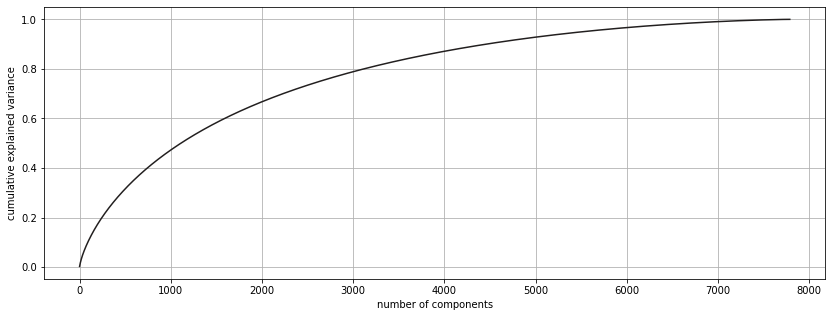

In [139]:
# Lets plot explained var v/s number of components to check how many components to be considered.
plt.figure(figsize=(14,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

From the above plot we can see that about 5000 components is enough to explain 92% of variance, lets just make it 95% in PCA tuned variable

In [140]:
#Scale data before applying PCA
pca_tuned = PCA(n_components=0.95)
pca_tuned.fit(movie_line_tfidf)
X_transformed = pca_tuned.transform(movie_line_tfidf)
X_transformed.shape 
#Checking the dimensions of data after PCA

(7787, 5514)

This Clustering of "description" is mainly done for Hypotesis Testing, so let's just take the K(no. of clusters) by simply taking the best value from Silhouette Score

In [142]:
#sillhoute score of clusters 
sill = [] 
for i in range(3,29):
    model = KMeans(n_clusters=i,init ='k-means++',random_state=51)
    model.fit(X_transformed)
    y1 = model.predict(X_transformed)
    score = silhouette_score(X_transformed,y1)
    sill.append(score)
    print('cluster: %d \t Sillhoute: %0.4f'%(i,score))

cluster: 2 	 Sillhoute: -0.0008
cluster: 3 	 Sillhoute: 0.0001
cluster: 4 	 Sillhoute: 0.0002
cluster: 5 	 Sillhoute: 0.0010
cluster: 6 	 Sillhoute: 0.0012
cluster: 7 	 Sillhoute: 0.0015
cluster: 8 	 Sillhoute: 0.0016
cluster: 9 	 Sillhoute: 0.0025
cluster: 10 	 Sillhoute: 0.0024
cluster: 11 	 Sillhoute: 0.0021
cluster: 12 	 Sillhoute: 0.0026
cluster: 13 	 Sillhoute: 0.0027
cluster: 14 	 Sillhoute: 0.0027
cluster: 15 	 Sillhoute: 0.0031
cluster: 16 	 Sillhoute: 0.0031
cluster: 17 	 Sillhoute: 0.0038
cluster: 18 	 Sillhoute: 0.0037
cluster: 19 	 Sillhoute: 0.0038
cluster: 20 	 Sillhoute: 0.0040
cluster: 21 	 Sillhoute: 0.0038
cluster: 22 	 Sillhoute: 0.0040
cluster: 23 	 Sillhoute: 0.0041
cluster: 24 	 Sillhoute: 0.0043
cluster: 25 	 Sillhoute: 0.0043
cluster: 26 	 Sillhoute: 0.0047
cluster: 27 	 Sillhoute: 0.0046
cluster: 28 	 Sillhoute: 0.0045
cluster: 29 	 Sillhoute: 0.0050


The best number of clusters from the above sillhoute score is K = 26, so lets just define the K value to our K-Means clustering 

In [146]:
#Kmeans clustering Implementation
Kmeans_clustersmodel= KMeans(n_clusters=26, init='k-means++', max_iter=100, n_init=1,random_state=51)
Kmeans_clustersmodel.fit(X_transformed)

KMeans(max_iter=100, n_clusters=26, n_init=1, random_state=51)

In [147]:
#Predicting from model and also checking centres_Cluster in arrays
pred= Kmeans_clustersmodel.predict(X_transformed)
centres_Cluster= Kmeans_clustersmodel.cluster_centers_
centres_Cluster

array([[ 7.27326133e-02, -4.22628545e-03,  2.98719995e-02, ...,
        -1.59384671e-05, -1.09634260e-04, -4.83618136e-04],
       [ 2.61835922e-02,  2.17975431e-02, -4.92371432e-03, ...,
         1.94487238e-04,  3.69303807e-06, -3.10740532e-04],
       [ 2.67377644e-02, -1.69189123e-02, -6.15103225e-03, ...,
        -1.12025705e-04,  5.47580893e-05, -4.79056454e-05],
       ...,
       [-4.46937712e-02, -3.53094266e-02,  3.47497024e-02, ...,
        -4.36274071e-04,  3.32257784e-04,  2.31057225e-04],
       [-8.42049215e-03, -2.09926174e-02,  9.91172252e-03, ...,
         6.72702990e-07,  2.90717349e-04, -1.55086590e-04],
       [ 1.92509360e-02,  1.43741870e-02, -7.60916755e-03, ...,
        -4.40448983e-06, -1.29096261e-04,  1.94369009e-04]])

In [148]:
# Making a copy of our orginal df
netflix_df = df.copy()

In [149]:
# Creating a column cluster and assigning predicted clusters in our orginal DataFrame
netflix_df['cluster'] = Kmeans_clustersmodel.labels_

In [150]:
# Checking if each clusters contain both movie and tv show
netflix_df[netflix_df.cluster == 4]["type"].value_counts()

movie      167
tv show     86
Name: type, dtype: int64

# Hypothesis Testing 

Before Hypothesis Testing we're making few assumptions based on clustering, recommendation and people's perspectives.

* Let's assume that the above clustered data is the actual recommendation for netflix customers. Ex: If a customer watches a movie from cluster 1, then his next recommended movie or tv show are from the same cluster 1.
* Recommendation for a customer is given based on top IMDB rated Movies and Tv Shows in that cluster. Ex: If a customer watched a movie or tv_show form cluster 1, his next recommendation have equal weightage to display him both top IMDB rated movie as well as tv show from cluster 1.
* Let's assume that people prefer to watch both movies and tv shows equaly (both movies and tv show have 50 % probability to be watched next), and they are more likely to watch movie or a tv show which has highest IMDB rating.

To summarize if i watch a movie "the departed", i would have a recommendation of both movie and tv_show with similar story line and are sorted with its IMDB rating (from highest to lowest rating) , i would prefer to watch either a movie or a tv show which has highest IMDB rating, obviously i would pick top rated amongst them.

So the **Hypothesis Test** here is to analyse if the people are more likely to watch tv show or a movie based on above assumption

* **Null Hypothesis**: Tv Show's mean rating is equal to Movie's mean rating.
* **Alternative Hypothesis**: Tv Shows mean rating is greater than Movie's mean rating

In [154]:
# grouping by cluster and taking the maximum rated movie and tv show in each clusters
grouped_sample = netflix_df.groupby(["cluster","type"])["averageRating"].max()
grouped_sample

cluster  type   
0        movie      8.1
         tv show    8.7
1        movie      8.0
         tv show    9.8
2        movie      8.4
         tv show    8.9
3        movie      8.4
         tv show    8.7
4        movie      8.1
         tv show    9.3
5        movie      8.9
         tv show    9.3
6        movie      8.6
         tv show    9.3
7        movie      9.2
         tv show    9.4
8        movie      8.5
         tv show    8.2
9        movie      9.0
         tv show    9.4
10       movie      8.9
         tv show    9.5
11       movie      8.1
         tv show    8.8
12       movie      8.3
         tv show    8.9
13       movie      8.4
         tv show    9.0
14       movie      8.4
         tv show    8.7
15       movie      8.4
         tv show    9.1
16       movie      9.0
         tv show    9.1
17       movie      9.0
         tv show    9.1
18       movie      8.2
         tv show    9.7
19       movie      8.2
         tv show    8.2
20       movie      9.0

Grouping clusters, type and taking maximum value in rating gives the tv shows top rating and movies top rating in that cluster, so that we can see which is more likely to be picked next to stream.

In [155]:
grouped_samples = grouped_sample.unstack(level="type")
grouped_samples

type,movie,tv show
cluster,,
0,8.1,8.7
1,8.0,9.8
2,8.4,8.9
3,8.4,8.7
4,8.1,9.3
5,8.9,9.3
6,8.6,9.3
7,9.2,9.4
8,8.5,8.2


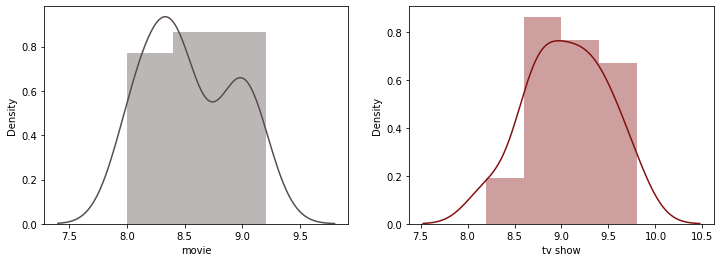

In [157]:
# checking if the samples are normally distributed
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(grouped_samples["movie"],color='#564d4d')
plt.subplot(1,2,2)
sns.distplot(grouped_samples["tv show"],color='#831010')

In [159]:
test_statistic = " Z  = (x1bar - x2bar)/np.sqrt((std1/n1)+ (std2/n2))"
print(f"{test_statistic}\n")
print("x1bar is mean of first sample")
print("x2bar is mean of second sample")
print("std1 is standard deviation of first population")
print("std2 is standard deviation of second population")
print("n1 is number of observations in first sample")
print("n2 is number of observations in second sample")

 Z  = (x1bar - x2bar)/np.sqrt((std1/n1)+ (std2/n2))

x1bar is mean of first sample
x2bar is mean of second sample
std1 is standard deviation of first sample
std2 is standard deviation of second sample
n1 is number of observations in first sample
n2 is number of observations in second sample


Due to the assumption that user have to pick any one from the top rated movie or tv show, this means that the standard deviation of population is equal to the standard deviation of samples, so we'll just calculate the above formula using sample stand dev.

In [161]:
Z0 = (grouped_samples["tv show"].mean() - grouped_samples["movie"].mean())/np.sqrt((grouped_samples["tv show"].std()/grouped_samples.shape[0]
                                                                                  + grouped_samples["movie"].std()/grouped_samples.shape[0]))
Z0

2.8948469774940393

In [162]:
from scipy.stats import norm
# P-value 
1 - norm.cdf(2.89,0,1)

0.029378980040409397

Using alpha = 0.05, Since p value is 0.0293 which is lesser than alpha value we reject the null hypothesis. There is sufficient evidence than the Tv Show's mean rating is greater than the Movies's mean rating

In the above problem statement "**The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled**."

* From the above hypothesis test and its assumption, it's valid that most of the user's may have been attracted to Tv Shows than movies because of its rating, people tend to watch highly rated content to explore what's so good about it, so that netflix made its Tv show availabilty three times morer.

* In this dataset after clustering similar story lines, we found that about 23 out of 26 cluster had higher rating in TvShows than Movies.

* After observing streaming rate for Tv Shows, Tvshows are lengthier and way more addictive, Netflix had made its availability three time more is my theory.

Also we can clearly see that out of 26 clusters Tv show's IMDB rating is higher than Movie's IMDB rating in 23 clusters, equal IMDB rating in 2 clusters and in one cluster Movie's rating is higher than Tv show's rating

In [ ]:
grouped_samples.T

In [151]:
# Cluster number 8 which had high IMDB rating for movie
cluster_8_movie = netflix_df.loc[(netflix_df["type"] == "movie")&(netflix_df["cluster"] == 8)&(netflix_df["averageRating"] == 8.5)]
cluster_8_tvshow = netflix_df.loc[(netflix_df["type"] == "tv show")&(netflix_df["cluster"] == 8)&(netflix_df["averageRating"] == 8.2)]
cluster_8_movie.append(cluster_8_tvshow)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes,month,year_added,runtime_in_min,target_ages,cluster
4635,s4636,movie,once upon a time in the west,Sergio Leone,"Henry Fonda, Charles Bronson, Claudia Cardinal...","Italy, United States",2019-11-20,1968,PG-13,166 min,"Action & Adventure, Classic Movies, Internatio...","In this epic spaghetti Western, a flinty gunsl...",165,8.5,326377.0,November,2019,166,Teens,8
5703,s5704,tv show,somebody feed phil,No Data,Philip Rosenthal,United States,2020-10-30,2020,TV-14,4 Seasons,"Docuseries, Reality TV","""Everybody Loves Raymond"" creator Phil Rosenth...",60,8.2,5194.0,October,2020,60,Teens,8


In [152]:
# cluster number 19 which had equal IMDB rating for both
cluster_19_movie = netflix_df.loc[(netflix_df["type"] == "movie")&(netflix_df["cluster"] == 19)&(netflix_df["averageRating"] == 8.2)]
cluster_19_tvshow = netflix_df.loc[(netflix_df["type"] == "tv show")&(netflix_df["cluster"] == 19)&(netflix_df["averageRating"] == 8.2)]
cluster_19_movie.append(cluster_19_tvshow)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes,month,year_added,runtime_in_min,target_ages,cluster
7769,s7770,movie,zindagi na milegi dobara,Zoya Akhtar,"Hrithik Roshan, Abhay Deol, Farhan Akhtar, Kat...",India,2019-12-15,2011,TV-14,154 min,"Comedies, Dramas, International Movies",Three friends on an adventurous road trip/bach...,155,8.2,77326.0,December,2019,154,Teens,19
3083,s3084,tv show,itaewon class,No Data,"Park Seo-joon, Kim Da-mi, Yu Jae-myeong, Kwon ...",South Korea,2020-02-01,2020,TV-MA,1 Season,"International TV Shows, Korean TV Shows, TV Dr...","In a colorful Seoul neighborhood, an ex-con an...",70,8.2,13113.0,February,2020,70,Adults,19


In [153]:
# cluster number 24 which had equal IMDB rating for both
cluster_24_movie = netflix_df.loc[(netflix_df["type"] == "movie")&(netflix_df["cluster"] == 24)&(netflix_df["averageRating"] == 9.1)]
cluster_24_tvshow = netflix_df.loc[(netflix_df["type"] == "tv show")&(netflix_df["cluster"] == 24)&(netflix_df["averageRating"] == 9.1)]
cluster_24_movie.append(cluster_24_tvshow)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,runtimeMinutes,averageRating,numVotes,month,year_added,runtime_in_min,target_ages,cluster
6049,s6050,movie,the 12th man,Harald Zwart,"Thomas Gullestad, Jonathan Rhys Meyers, Marie ...",Norway,2020-10-31,2018,TV-MA,130 min,"Action & Adventure, Dramas, International Movies","Based on true events, this story follows a Nor...",35,9.1,403.0,October,2020,130,Adults,24
6424,s6425,tv show,the great train robbery,No Data,"Luke Evans, Jim Broadbent, Paul Anderson, Mart...",United Kingdom,2017-03-31,2013,NR,1 Season,"British TV Shows, Crime TV Shows, Internationa...",This two-part tale delivers the true story of ...,30,9.1,429.0,March,2017,30,Adults,24


In [164]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [165]:
! pip install umap-learn
import umap.umap_ as umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=4490aff049dae037db56b6782653a5facc28376a45ee50e3c617d33602f1f4c5
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=96818d8c40848c1291cfd6d1bda1ce7d469488cde72868edd9296a8134637027
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [166]:
from sklearn.preprocessing import normalize

In [167]:
df = pd.read_csv("/content/drive/MyDrive/data/project/netflix_imdb.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s28,movie,#alive,Cho Il,"Yoo Ah-in, Park Shin-hye",South Korea,"September 8, 2020",2020,TV-MA,99 min,"Horror Movies, International Movies, Thrillers","As a grisly virus rampages a city, a lone man ...",movie,#alive,#saraitda,0.0,2020.0,\N,98,"Action,Drama,Horror",6.3,38671.0
1,s29,movie,#annefrank - parallel stories,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",Italy,"July 1, 2020",2019,TV-14,95 min,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,s30,tv show,#blackaf,NaN,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,"April 17, 2020",2020,TV-MA,1 Season,TV Comedies,Kenya Barris and his family navigate relations...,tv show,#blackaf,#blackaf,0.0,2020.0,2020,36,Comedy,6.6,4850.0
3,s31,movie,#cats_the_mewvie,Michael Margolis,NaN,Canada,"February 5, 2020",2020,TV-14,90 min,"Documentaries, International Movies",This pawesome documentary explores how our fel...,movie,#cats_the_mewvie,#cats_the_mewvie,0.0,2020.0,\N,90,Documentary,5.3,468.0
4,s32,movie,#friendbutmarried,Rako Prijanto,"Adipati Dolken, Vanesha Prescilla, Rendi Jhon,...",Indonesia,"May 21, 2020",2018,TV-G,102 min,"Dramas, International Movies, Romantic Movies","Pining for his high school crush for years, a ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [168]:
df['director'] = df['director'].astype(str)
df['cast'] = df['cast'].astype(str)
df['country'] = df['country'].astype(str)

In [169]:
df1 = df.copy()

In [170]:
df1["director"] = df["director"].apply(lambda x : x.split(", ")[0])
df1["cast"] = df["cast"].apply(lambda x : x.split(", ")[0])
df1["country"] = df["country"].apply(lambda x : x.split(", ")[0])
df1["listed_in"] = df["listed_in"].apply(lambda x : x.split(", "))

In [171]:
df1.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s28,movie,#alive,Cho Il,Yoo Ah-in,South Korea,"September 8, 2020",2020,TV-MA,99 min,"[Horror Movies, International Movies, Thrillers]","As a grisly virus rampages a city, a lone man ...",movie,#alive,#saraitda,0.0,2020.0,\N,98,"Action,Drama,Horror",6.3,38671.0
1,s29,movie,#annefrank - parallel stories,Sabina Fedeli,Helen Mirren,Italy,"July 1, 2020",2019,TV-14,95 min,"[Documentaries, International Movies]","Through her diary, Anne Frank's story is retol...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,s30,tv show,#blackaf,nan,Kenya Barris,United States,"April 17, 2020",2020,TV-MA,1 Season,[TV Comedies],Kenya Barris and his family navigate relations...,tv show,#blackaf,#blackaf,0.0,2020.0,2020,36,Comedy,6.6,4850.0
3,s31,movie,#cats_the_mewvie,Michael Margolis,nan,Canada,"February 5, 2020",2020,TV-14,90 min,"[Documentaries, International Movies]",This pawesome documentary explores how our fel...,movie,#cats_the_mewvie,#cats_the_mewvie,0.0,2020.0,\N,90,Documentary,5.3,468.0
4,s32,movie,#friendbutmarried,Rako Prijanto,Adipati Dolken,Indonesia,"May 21, 2020",2018,TV-G,102 min,"[Dramas, International Movies, Romantic Movies]","Pining for his high school crush for years, a ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [172]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

mlb_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(df1.pop('listed_in')),index=df1.index,
                                                           columns=mlb.classes_)

In [173]:
mlb_df.shape

(7787, 42)

In [174]:
df1.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'description', 'titleType',
       'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes'],
      dtype='object')

In [175]:
def one_hot_encode(df, columns):
  '''
  one hot encodes list of columns and
  concatenates them to the original df
  '''

  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns

  return concat_df, one_hot_cols
  

cat_cols = ["type","director","cast","country","rating"]
df_one_hot, _ = one_hot_encode(df1, cat_cols)

In [176]:
df_one_hot.shape

(7787, 8947)

In [177]:
df_oh = mlb_df.join(df_one_hot)
df_oh.shape

(7787, 8989)

In [178]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [179]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
! pip install umap-learn
import umap.umap_ as umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [181]:
umap_embedding = (umap.UMAP(metric='euclidean', n_neighbors=200, n_components=10, random_state = 101, ).fit_transform(df_oh))
dataframe = preprocessing.StandardScaler().fit_transform(umap_embedding)


In [182]:
from sklearn.preprocessing import normalize

In [183]:
X=normalize(dataframe)
X.shape

(7787, 10)

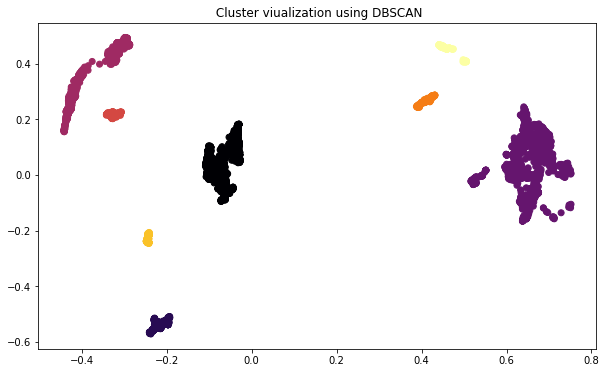

In [195]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
y_pred = DBSCAN(eps=0.2, min_samples=5, algorithm ='auto', leaf_size = 25, ).fit_predict(X)
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1], c=y_pred, cmap = 'inferno')
plt.title(' Cluster viualization using DBSCAN')
plt.show()

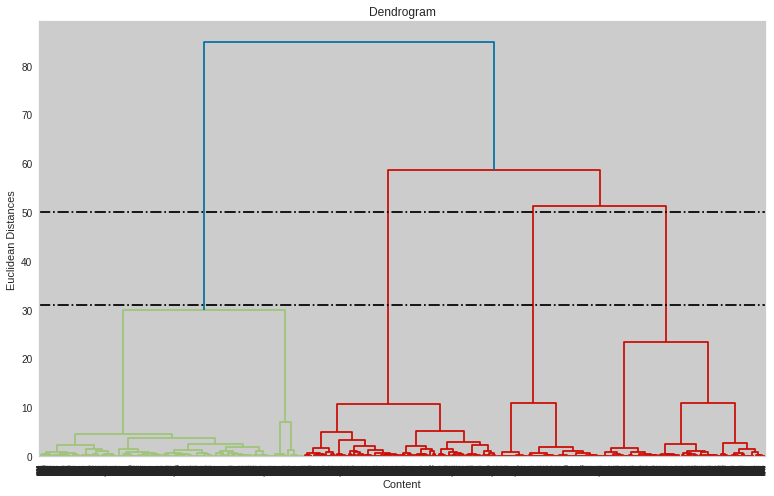

In [221]:
# Let's import sch
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(13,8))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Content')
plt.axhline(y=31, color='black', linestyle='-.')
plt.axhline(y=50, color='black', linestyle='-.')
plt.ylabel('Euclidean Distances')
plt.show() # find largest vertical distance we can make without crossing any other horizontal line

In [219]:
# Let's  import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ="complete")
y_hc = hc.fit_predict(X)

In [215]:
y_hc

array([1, 0, 0, ..., 0, 1, 0])

In [216]:
'#831010''#564d4d'

'#831010#564d4d'

<function matplotlib.pyplot.show(*args, **kw)>

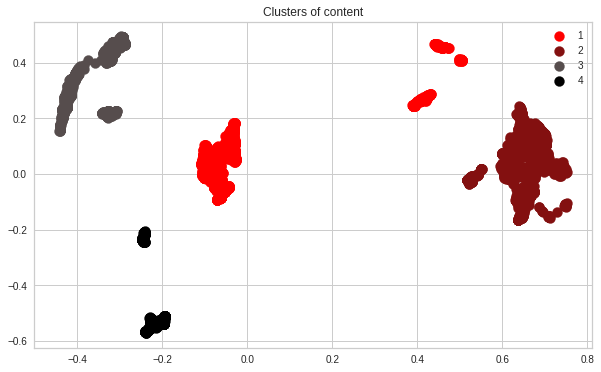

In [222]:
# Visualizing the clusters (three dimensions only)
plt.figure(figsize=(10,6))

plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = '#831010', label = '2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = '#564d4d', label = '3')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'black', label = '4')

plt.title('Clusters of content')

plt.legend()
plt.show

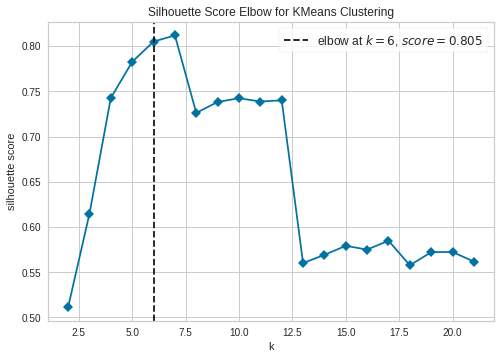

In [205]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=5)
visualizer = KElbowVisualizer(model, k=(2,22), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(X)
visualizer.show()

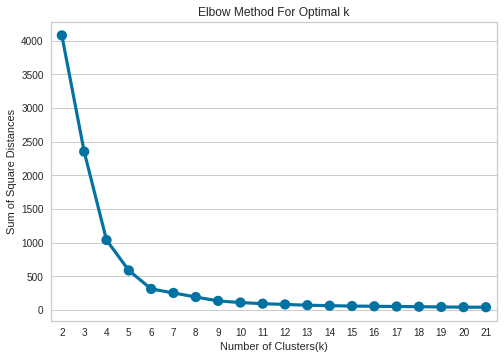

In [197]:
sum_of_sq_dist = {}
for k in range(2,22):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [200]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

def silhouette_score_analysis(n):

  for n_clusters in range(2,n):
      km = KMeans (n_clusters=n_clusters, random_state=5)
      preds = km.fit_predict(X)
      centers = km.cluster_centers_

      score = silhouette_score(X, preds, metric='euclidean')
      print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

      visualizer = SilhouetteVisualizer(km)

      visualizer.fit(X) # Fit the training data to the visualizer
      visualizer.show() # Draw/show/poof the data

For n_clusters = 2, silhouette score is 0.511311411857605


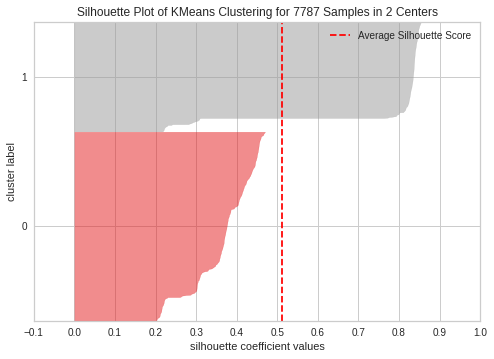

For n_clusters = 3, silhouette score is 0.6146807670593262


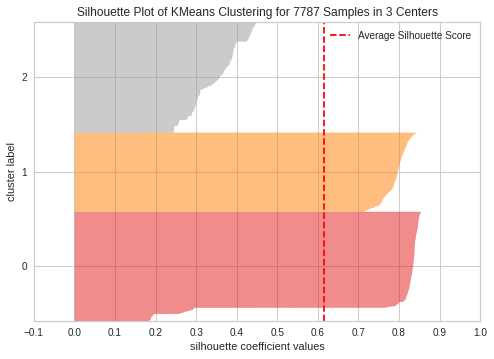

For n_clusters = 4, silhouette score is 0.7426762580871582


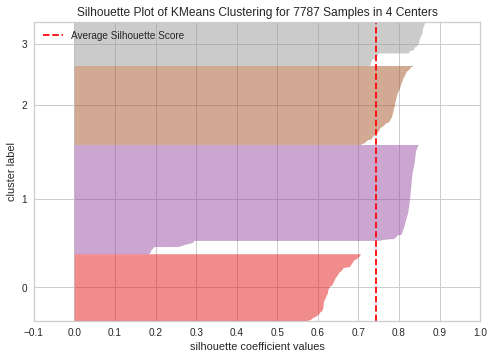

For n_clusters = 5, silhouette score is 0.7825334668159485


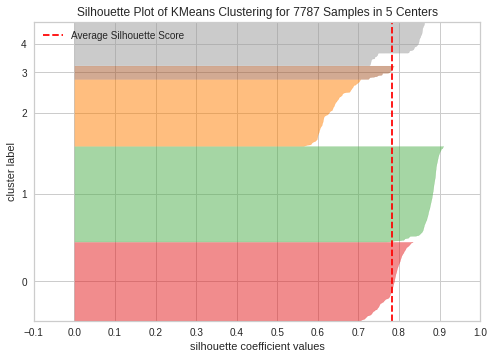

For n_clusters = 6, silhouette score is 0.8049270510673523


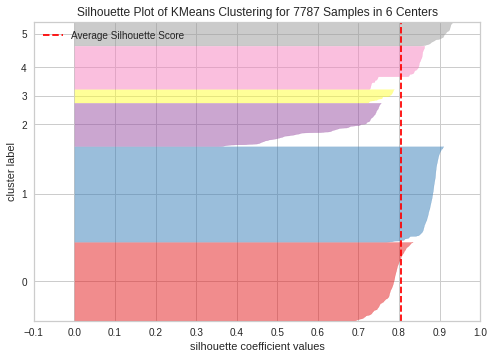

For n_clusters = 7, silhouette score is 0.8117616176605225


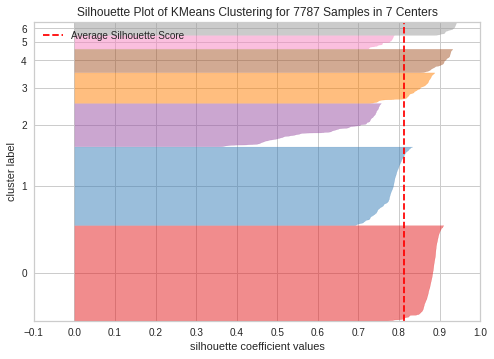

For n_clusters = 8, silhouette score is 0.7261150479316711


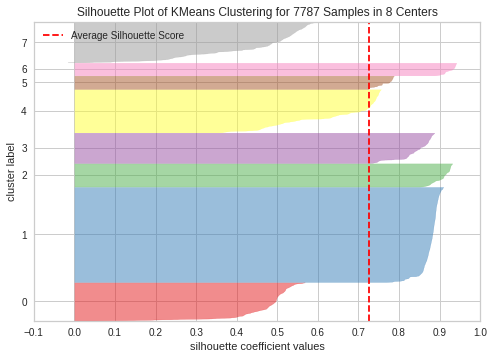

For n_clusters = 9, silhouette score is 0.7381647229194641


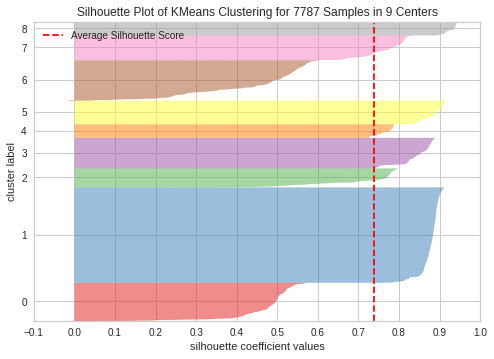

For n_clusters = 10, silhouette score is 0.7423354983329773


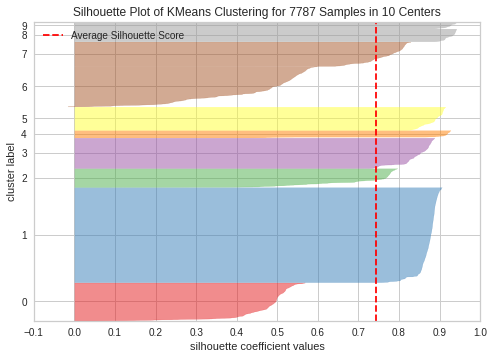

For n_clusters = 11, silhouette score is 0.7387012839317322


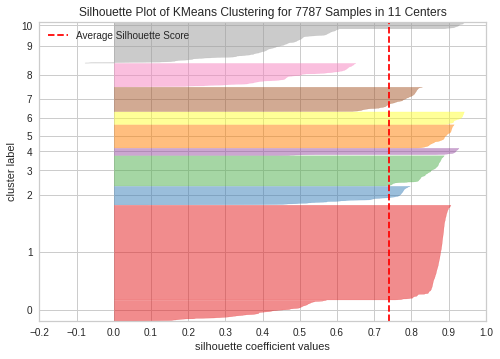

For n_clusters = 12, silhouette score is 0.7400127649307251


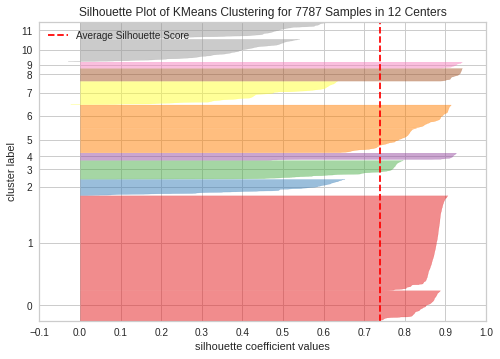

For n_clusters = 13, silhouette score is 0.5600987672805786


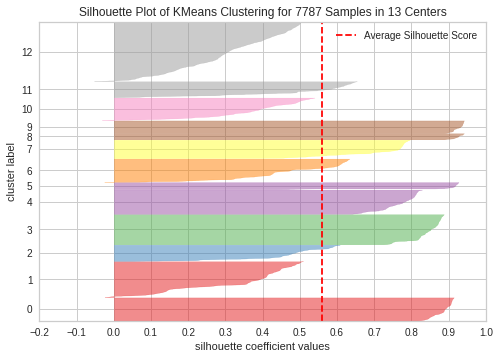

For n_clusters = 14, silhouette score is 0.5691962838172913


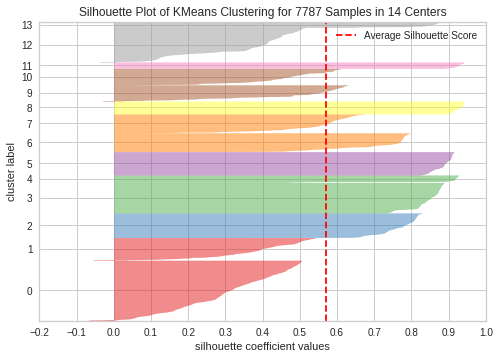

For n_clusters = 15, silhouette score is 0.5791590213775635


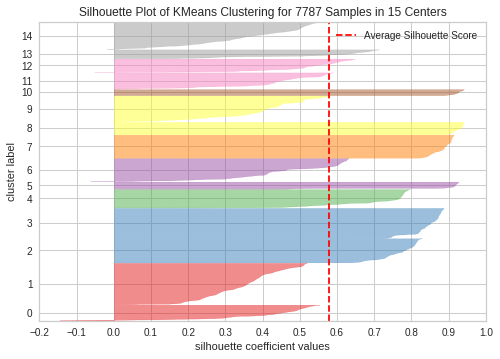

For n_clusters = 16, silhouette score is 0.574968159198761


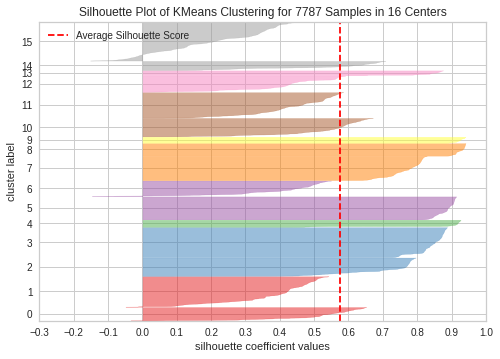

For n_clusters = 17, silhouette score is 0.5848413109779358


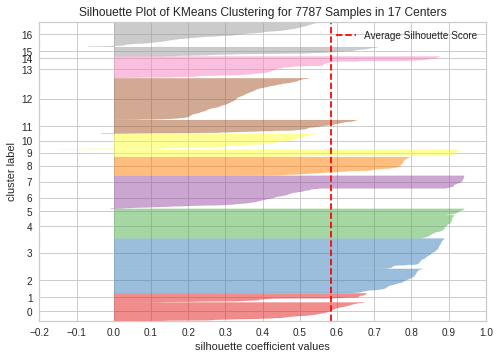

For n_clusters = 18, silhouette score is 0.5576689839363098


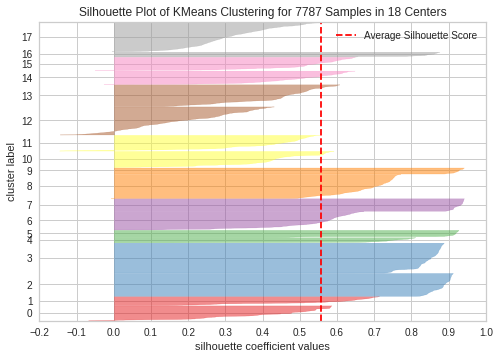

For n_clusters = 19, silhouette score is 0.572192370891571


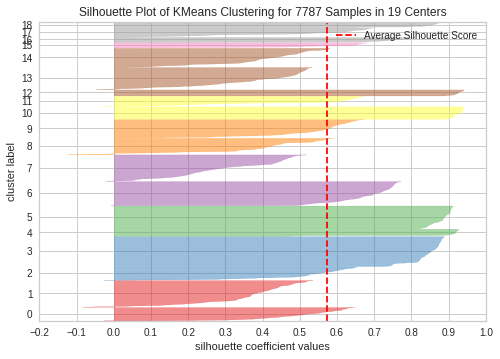

In [201]:
silhouette_score_analysis(20)

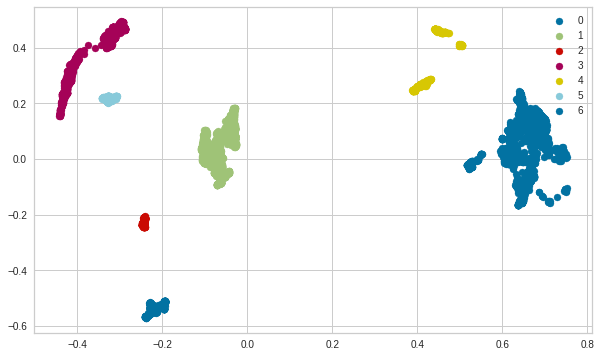

In [226]:
plt.figure(figsize=(10,6))

kmeans= KMeans(n_clusters=7, init= 'k-means++', random_state=9)
kmeans.fit(X)

#predict the labels of clusters.
label = kmeans.fit_predict(X)
#Getting unique labels
unique_labels = np.unique(label)
 
#plotting the results:
for i in unique_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i,cmap = 'inferno')
plt.legend()
plt.show()